In [1]:
%matplotlib inline

import cv2
import json
import math
import matplotlib.pyplot as plt
import numpy as np

In /home/dennis/tools/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/dennis/tools/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/dennis/tools/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/dennis/tools/anaconda3/envs/tensorflow2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be re

In [2]:
DATA_FILE = '/home/dennis/projects/wcc/data.npy'
META_FILE = '/home/dennis/projects/wcc/data.json'

In [3]:
with open(DATA_FILE, 'rb') as f:
    use_samples = np.load(f)
    use_probs = np.load(f)
    test_samples = np.load(f)
    test_probs = np.load(f)
with open(META_FILE, 'r') as f:
    metadata = json.load(f)

In [36]:
INPUT_SHAPE = (64, 64, 3)
MIN_OVERLAP = 16
OUTPUT_SCALE = 2
OUTPUT_SHAPE = ((INPUT_SHAPE[0] // OUTPUT_SCALE), (INPUT_SHAPE[1] // OUTPUT_SCALE))
MINIMUM_TARGET_VALUE = 0.001
MIN_DENSITY = .04
PIXEL_MULTIPLE = 4
MIN_DIMENSION = INPUT_SHAPE[0] + MIN_OVERLAP

In [9]:
actuals = (use_probs * 255).astype(np.uint8)
select_present = actuals.sum(axis=(1,2)) > MINIMUM_TARGET_VALUE
print(f'present selection has shape {select_present.shape}')
working_samples = use_samples[select_present]
working_actuals = actuals[select_present]
print(f'working with {len(working_samples)} samples and {len(working_actuals)} matching non-zero actuals out of {len(use_probs)} inputs')
working_names = [metadata['use_names'][i // 6] for i in range(len(select_present)) if select_present[i]]
working_names

present selection has shape (84,)
working with 12 samples and 12 matching non-zero actuals out of 84 inputs


['BQ31_500_042066',
 'BQ31_500_042066',
 'BQ31_500_042065',
 'BQ31_500_044065',
 'BQ31_500_044065',
 'BQ31_500_043066',
 'BQ31_500_043066',
 'BQ31_500_042064',
 'BQ31_500_041065',
 'BQ31_500_041065',
 'BQ31_500_041065',
 'BQ31_500_041068']

In [43]:
def adjust_to_bounds(low, high, limit, divisor, minsize):
    low = min(max(low, 0), limit)
    high = min(max(high, 0), limit)
    diff = high - low
    if diff < minsize:
        adjust = minsize - diff
        low = min(max(low-adjust, 0), limit)
        high = low + minsize
    extra = diff % divisor
    if extra != 0:
        adjust = divisor - extra
        if low > adjust:
            low -= adjust
        else:
            high += adjust
    return low, high

def crop_to_actual(image, actual, margin, divisor, minsize):
    for t in range(image.shape[0]):
        if actual[t].sum() > 0:
            break
    for b in range(image.shape[0]-1, -1, -1):
        if actual[b].sum() > 0:
            break
    for l in range(image.shape[1]):
        if actual[:,l].sum() > 0:
            break
    for r in range(image.shape[1]-1, -1, -1):
        if actual[:,r].sum() > 0:
            break
    limit = image.shape[0]
    t, b = adjust_to_bounds(t-margin, b+margin, limit, divisor, minsize)
    l, r = adjust_to_bounds(l-margin, r+margin, limit, divisor, minsize)
    #print(f'{t}, {b}, {l}, {r}')
    return image[t:b, l:r], actual[t:b, l:r]

In [30]:
cropped_samples, cropped_actuals = [], []
for index in range(len(working_samples)):
    sample, actual = crop_to_actual(working_samples[index], working_actuals[index], MIN_OVERLAP, 4)
    cropped_samples.append(sample)
    cropped_actuals.append(actual)

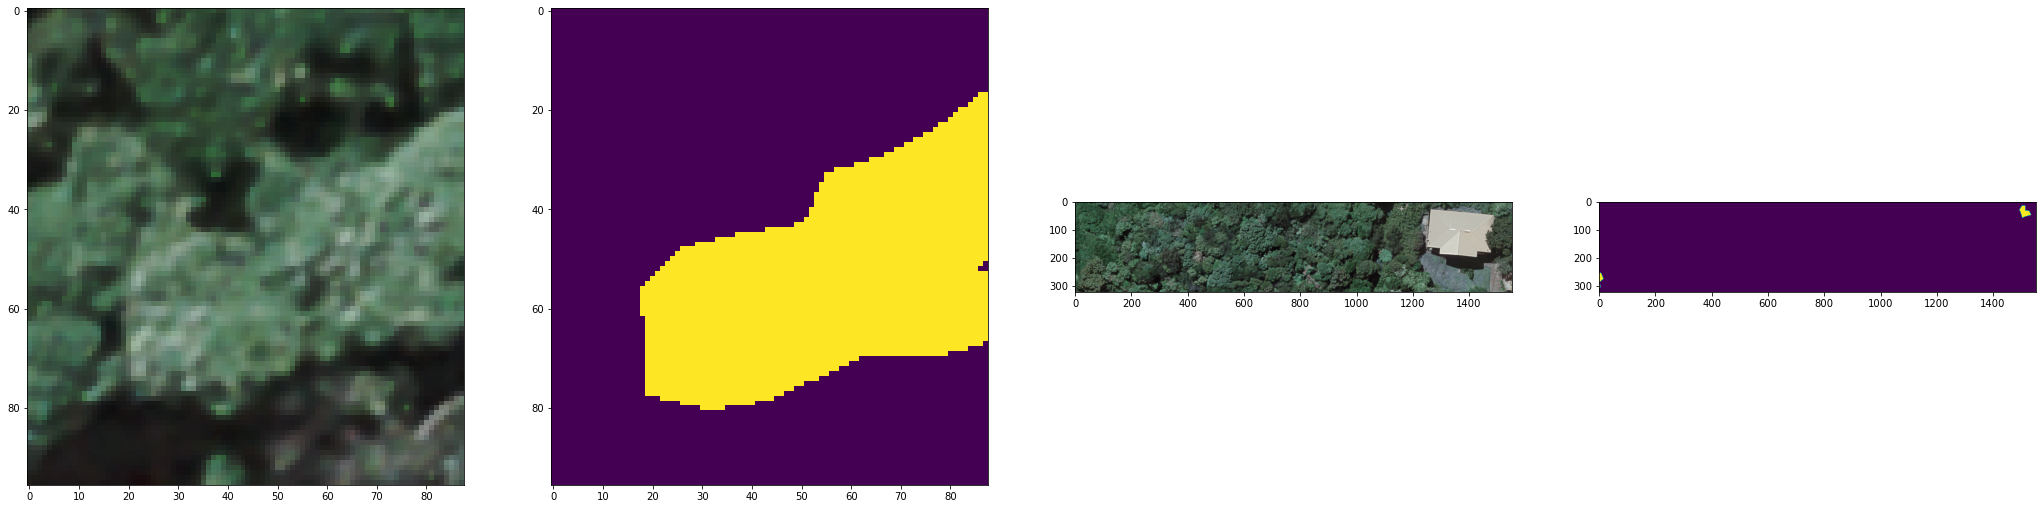

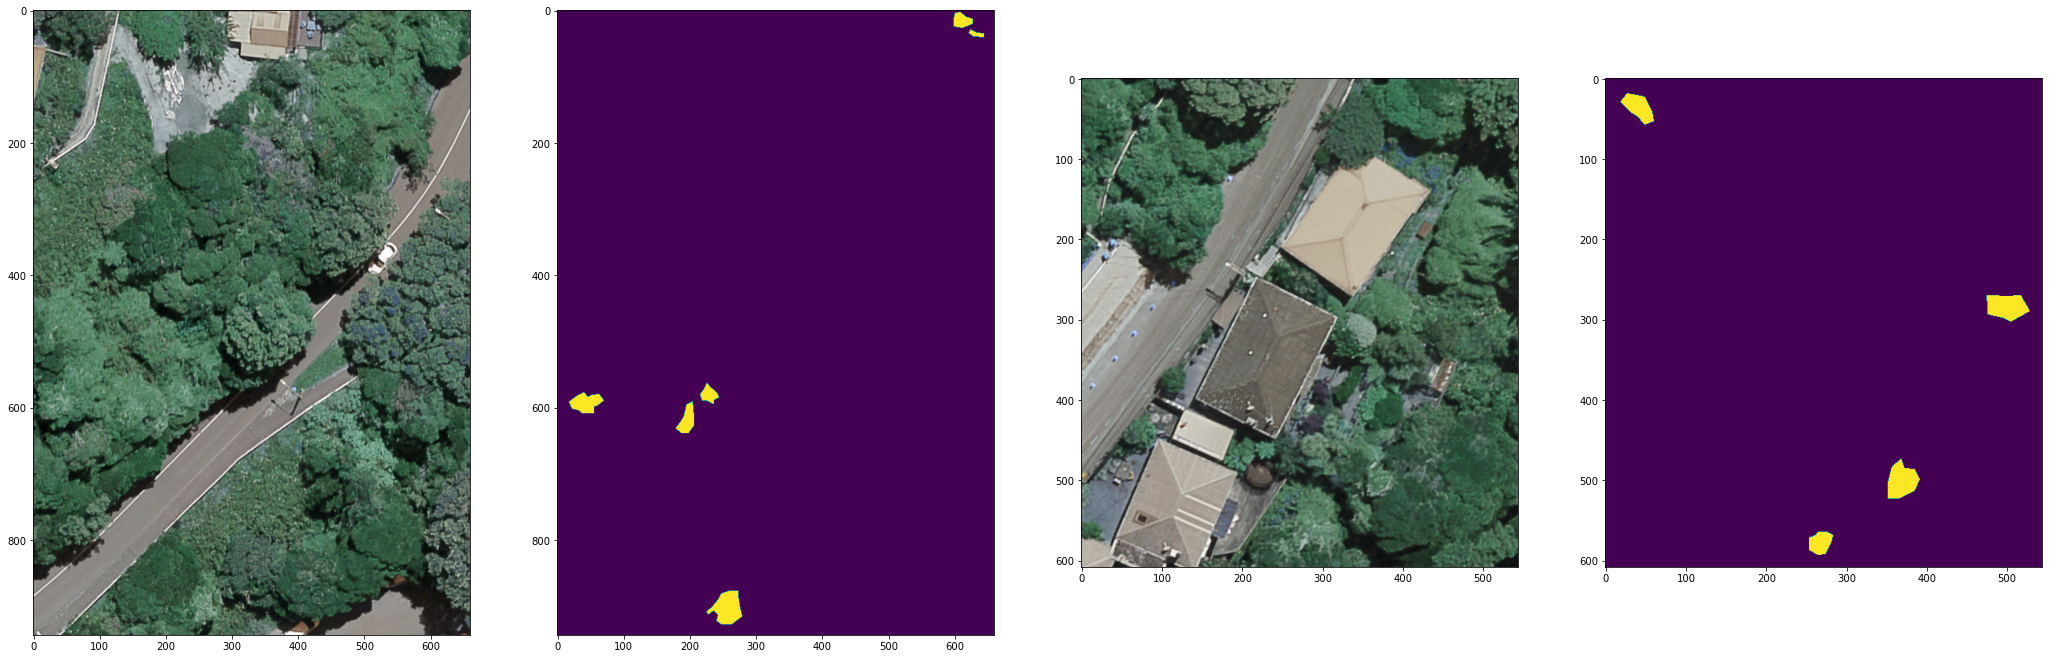

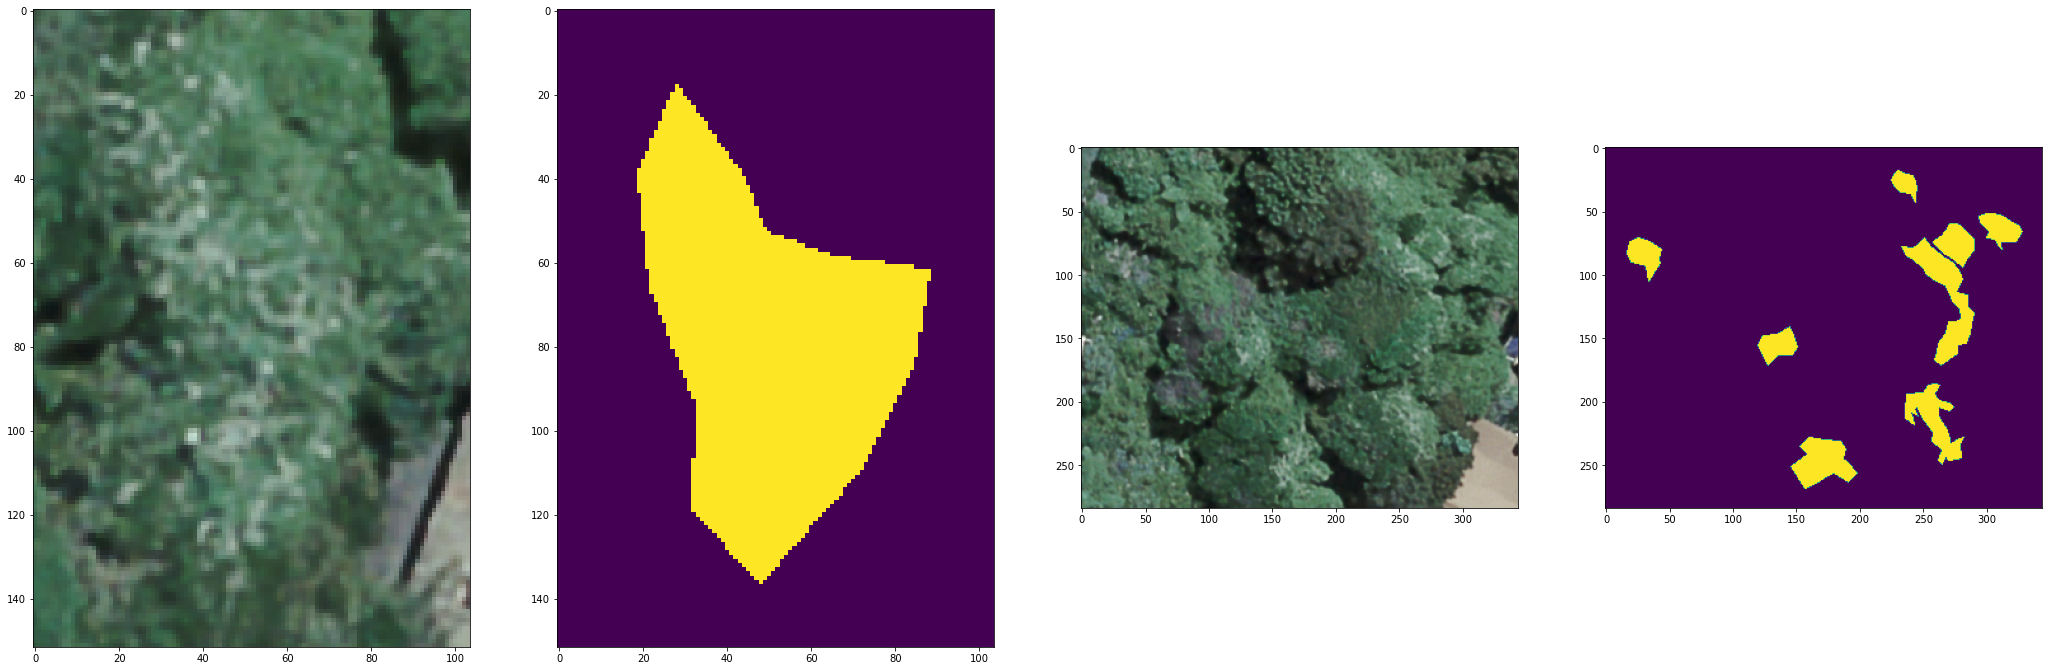

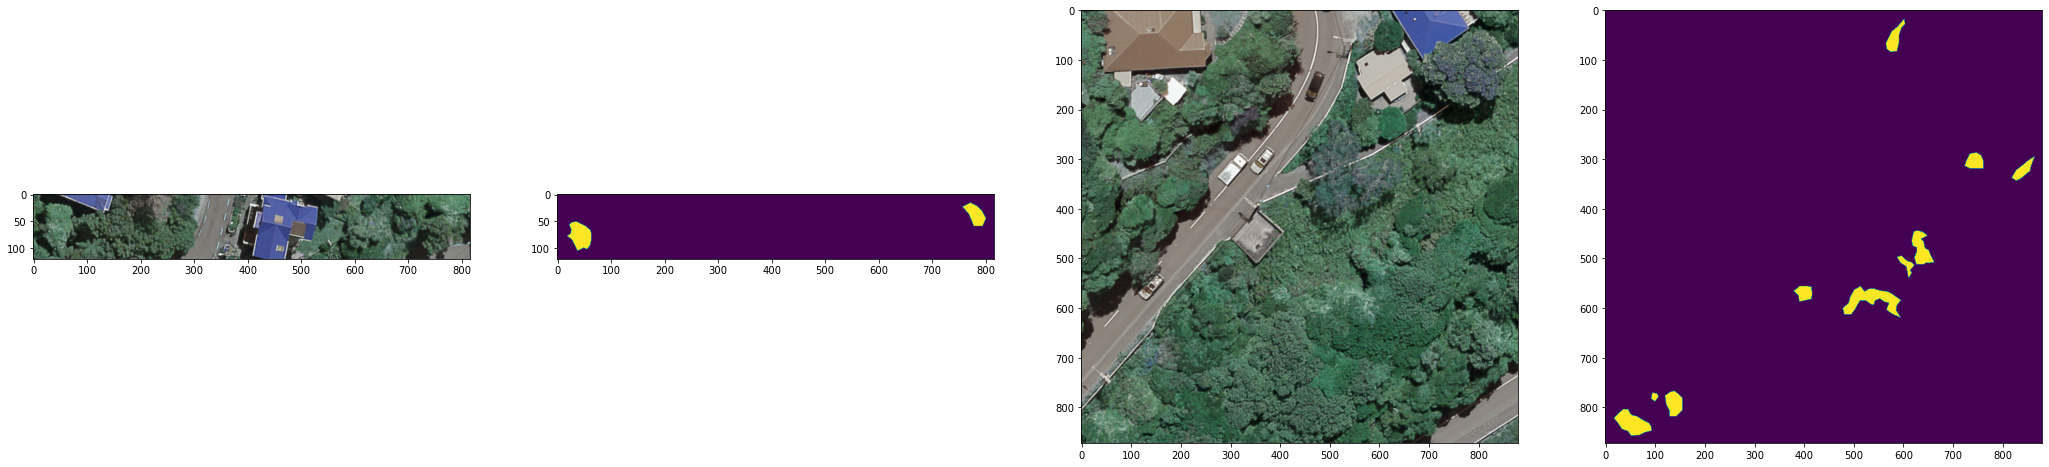

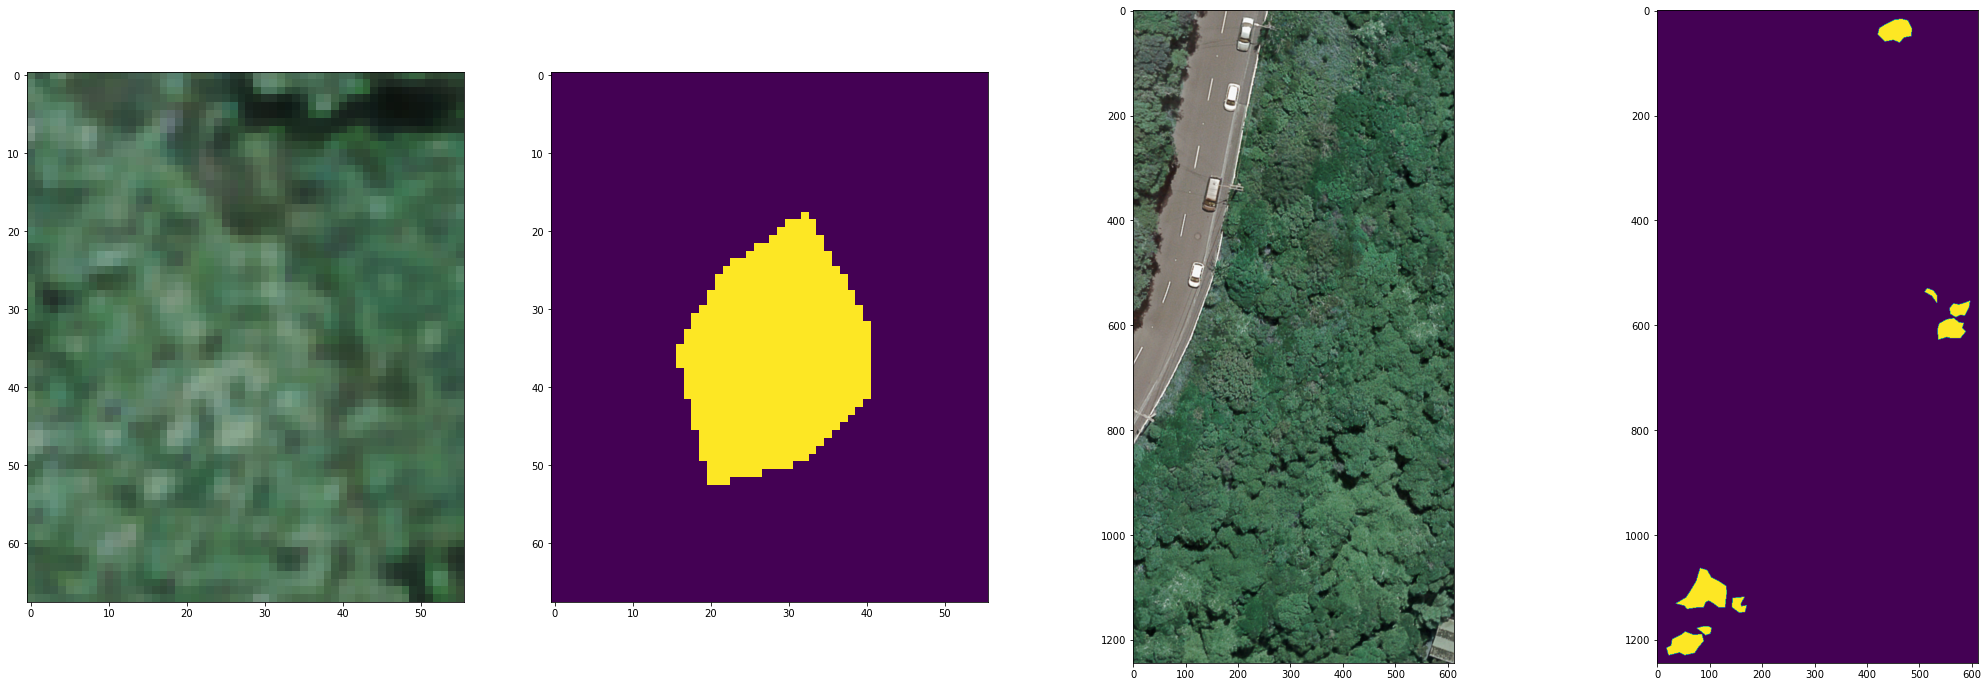

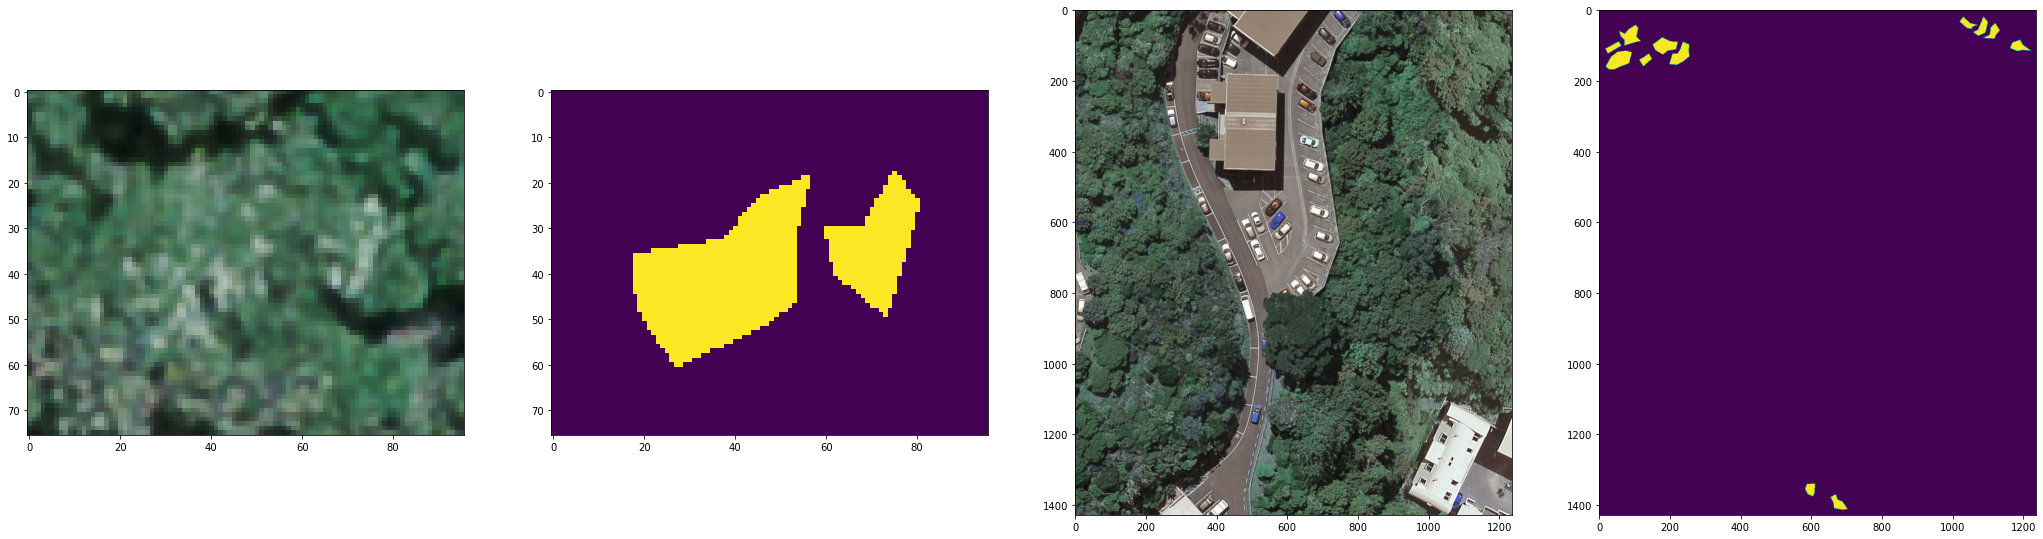

In [31]:
for base_index in range(0, len(cropped_samples), 2):
    fig, ax = plt.subplots(1, 4, figsize=(36,12))
    ax[0].imshow(cropped_samples[base_index])
    ax[1].imshow(cropped_actuals[base_index])
    ax[2].imshow(cropped_samples[base_index+1])
    ax[3].imshow(cropped_actuals[base_index+1])
    plt.show()

In [44]:
def collect_usable_crops(image, actual, samples, actuals):
    if image.shape[0] >= MIN_DIMENSION and image.shape[1] >= MIN_DIMENSION:
        sample, actual = crop_to_actual(image, actual, MIN_OVERLAP, PIXEL_MULTIPLE, MIN_DIMENSION)
        labeled_count = (actual > MINIMUM_TARGET_VALUE).sum()
        ratio = labeled_count / (sample.shape[0] * sample.shape[1])
        if ratio > MIN_DENSITY:
            samples.append(sample)
            actuals.append(actual)
        else:
            half_h = sample.shape[0] // 2
            half_w = sample.shape[1] // 2
            collect_usable_crops(sample[:half_h+PIXEL_MULTIPLE, :half_w+PIXEL_MULTIPLE], actual[:half_h+PIXEL_MULTIPLE, :half_w+PIXEL_MULTIPLE], samples, actuals)
            collect_usable_crops(sample[half_h-PIXEL_MULTIPLE:, :half_w+PIXEL_MULTIPLE], actual[half_h-PIXEL_MULTIPLE:, :half_w+PIXEL_MULTIPLE], samples, actuals)
            collect_usable_crops(sample[:half_h+PIXEL_MULTIPLE, half_w-PIXEL_MULTIPLE:], actual[:half_h+PIXEL_MULTIPLE, half_w-PIXEL_MULTIPLE:], samples, actuals)
            collect_usable_crops(sample[half_h-PIXEL_MULTIPLE:, half_w-PIXEL_MULTIPLE:], actual[half_h-PIXEL_MULTIPLE:, half_w-PIXEL_MULTIPLE:], samples, actuals)

In [49]:
cropped_samples, cropped_actuals, cropped_names = [], [], []
for index in range(len(working_samples)):
    collect_usable_crops(working_samples[index], working_actuals[index], cropped_samples, cropped_actuals)
    while len(cropped_names) < len(cropped_samples):
        cropped_names.append(working_names[index])
len(cropped_samples)

26

BQ31_500_042066


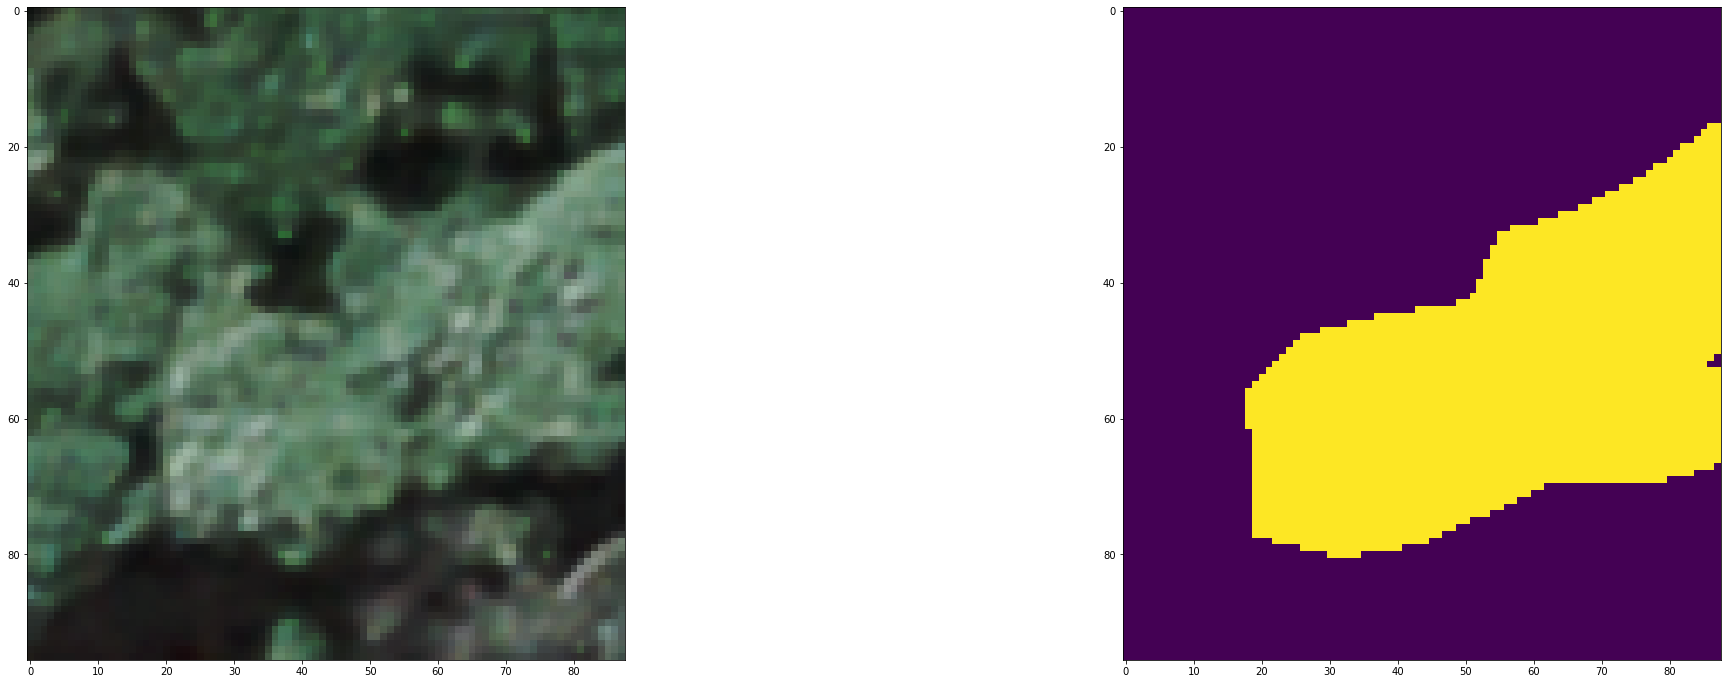

BQ31_500_042066


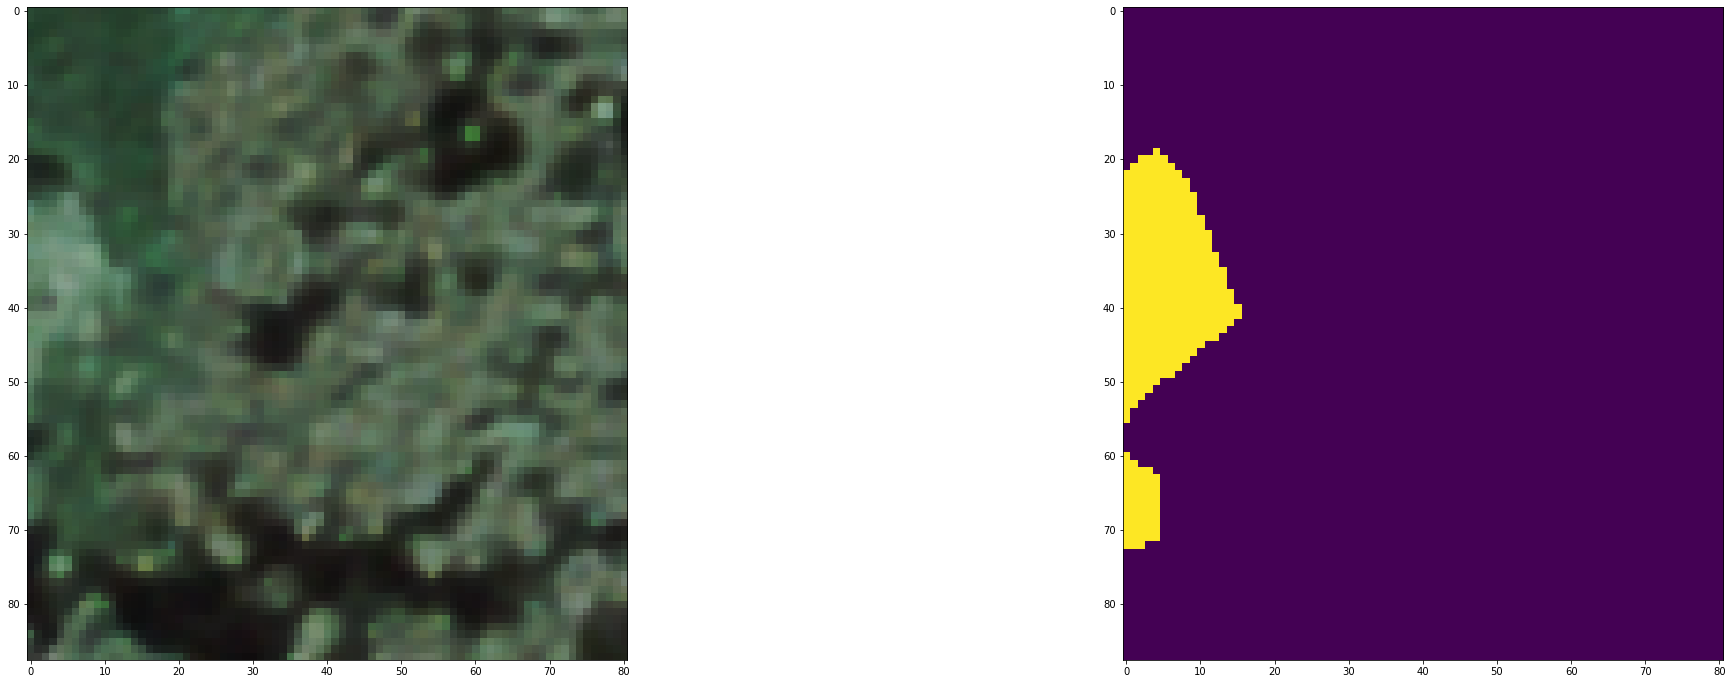

BQ31_500_042065


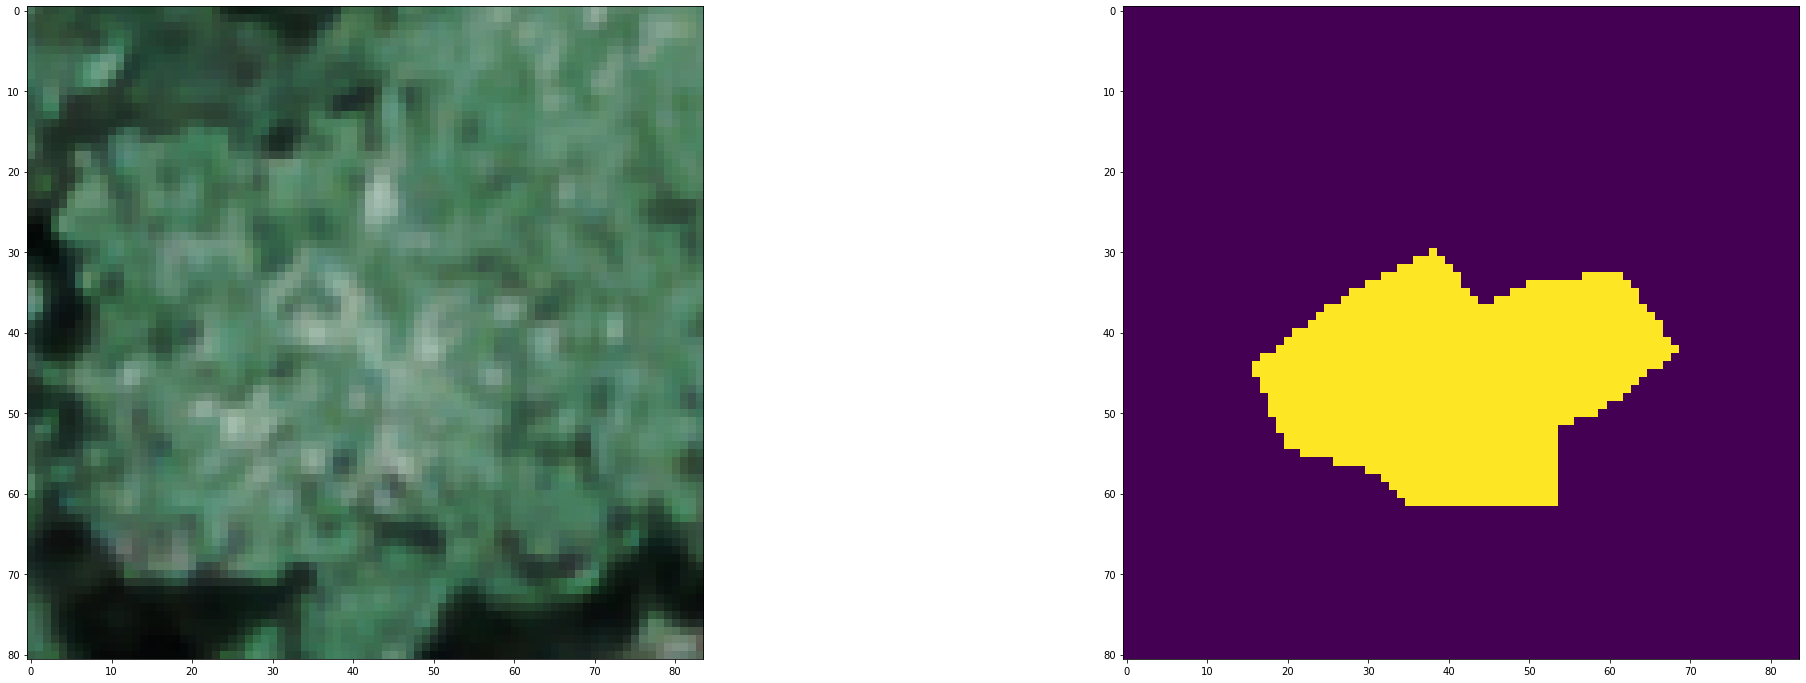

BQ31_500_042065


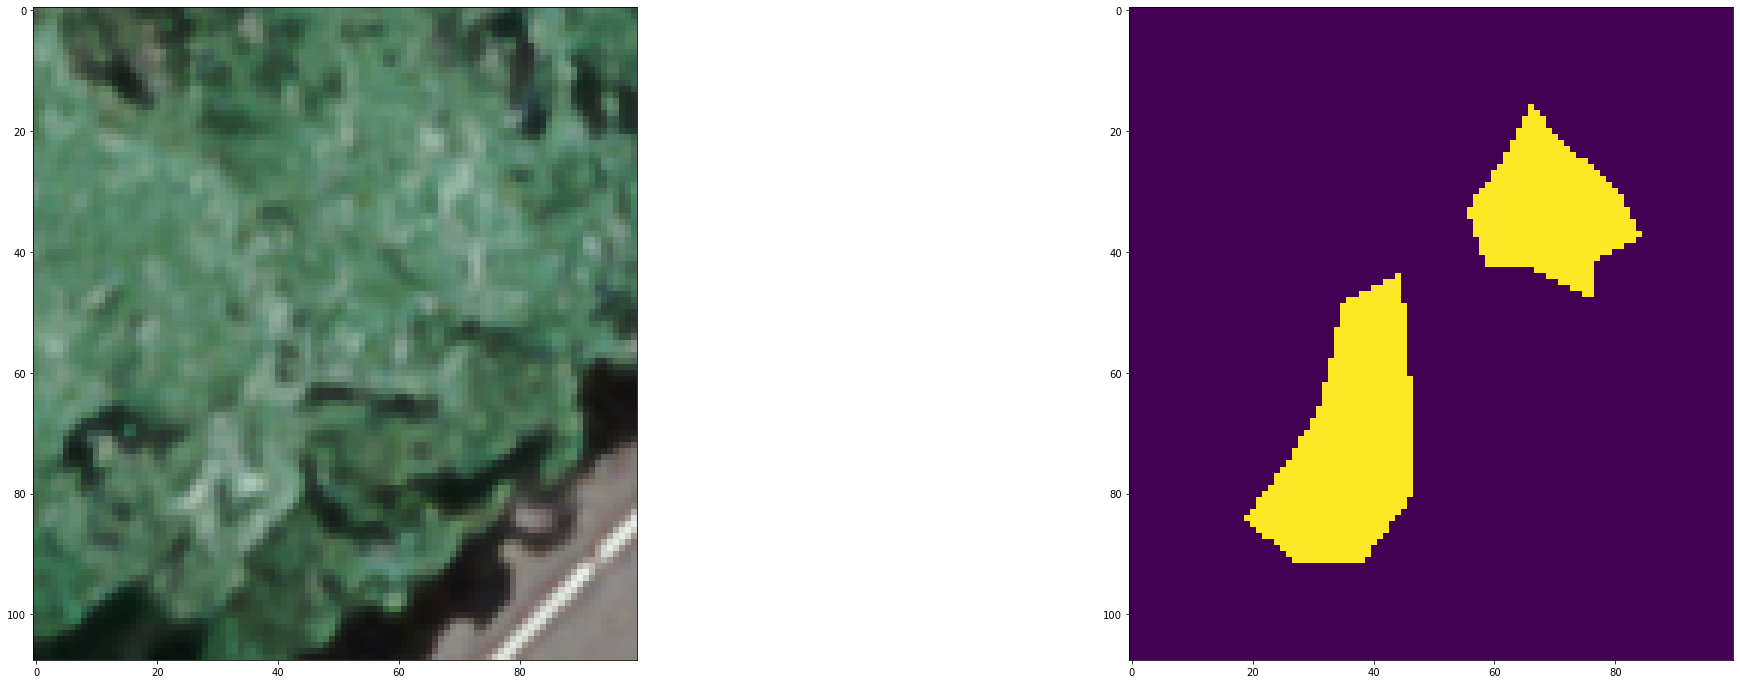

BQ31_500_042065


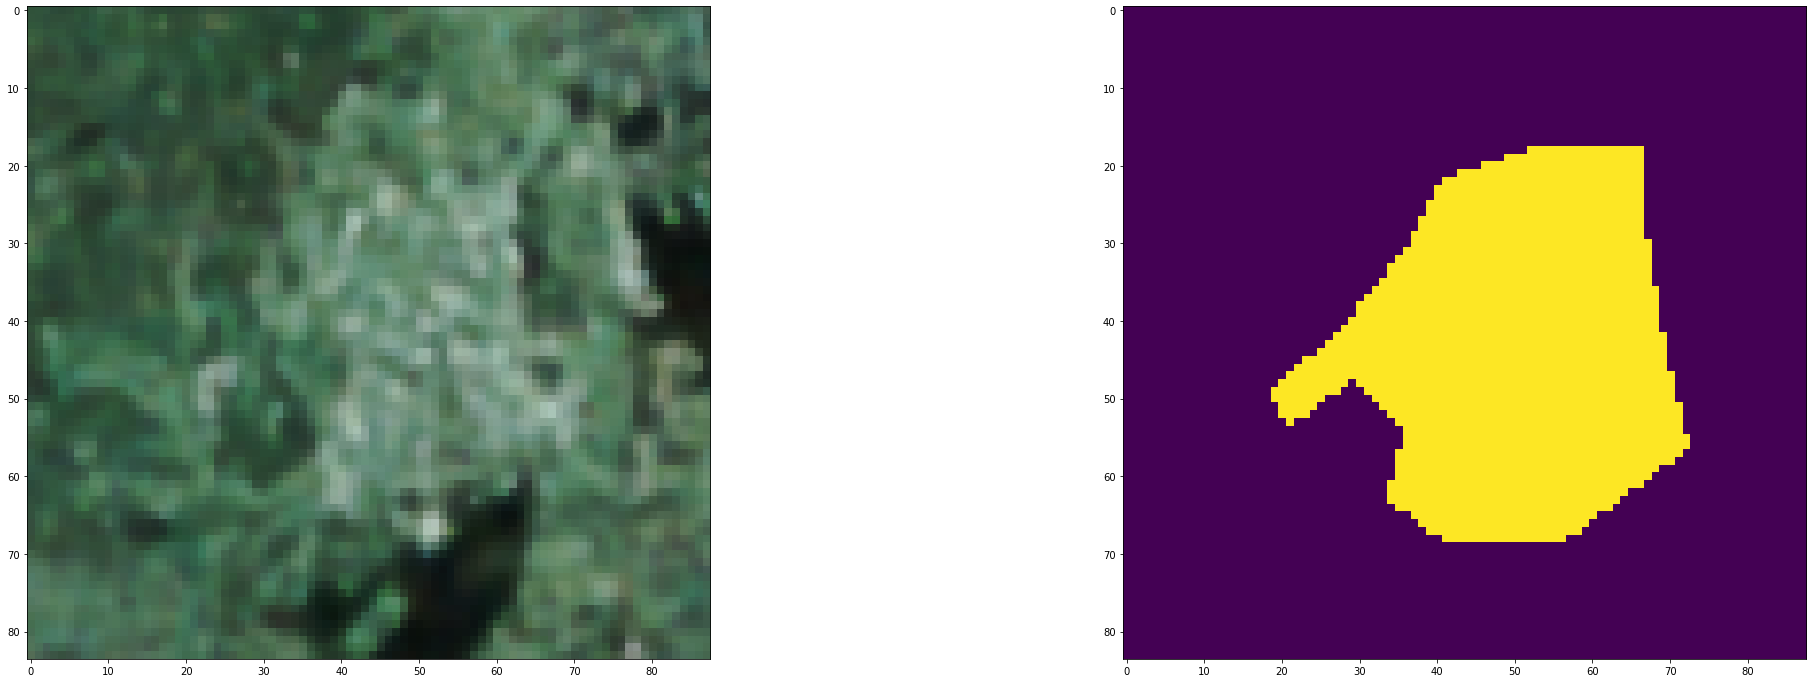

BQ31_500_042065


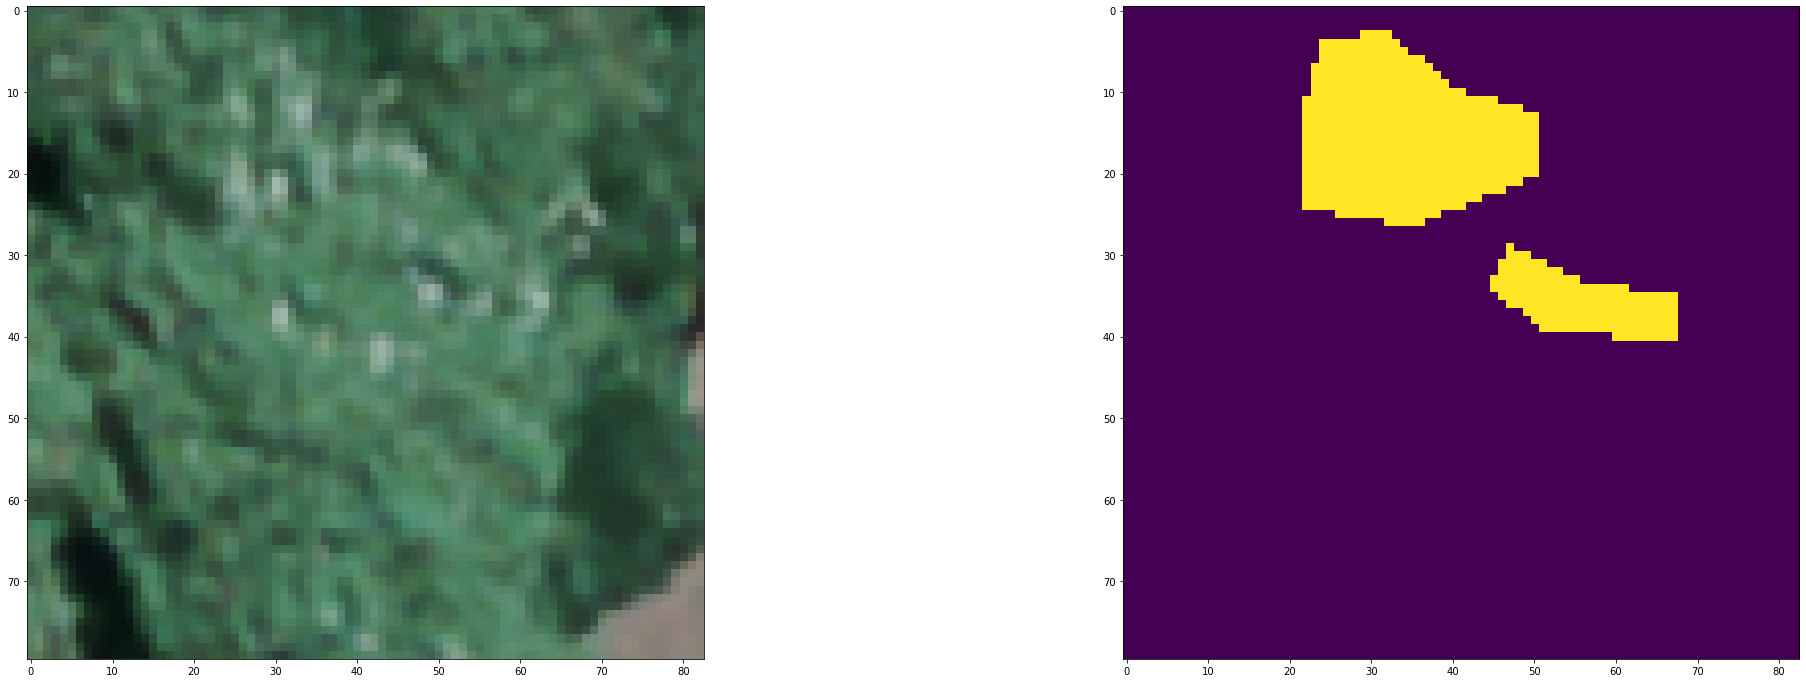

BQ31_500_044065


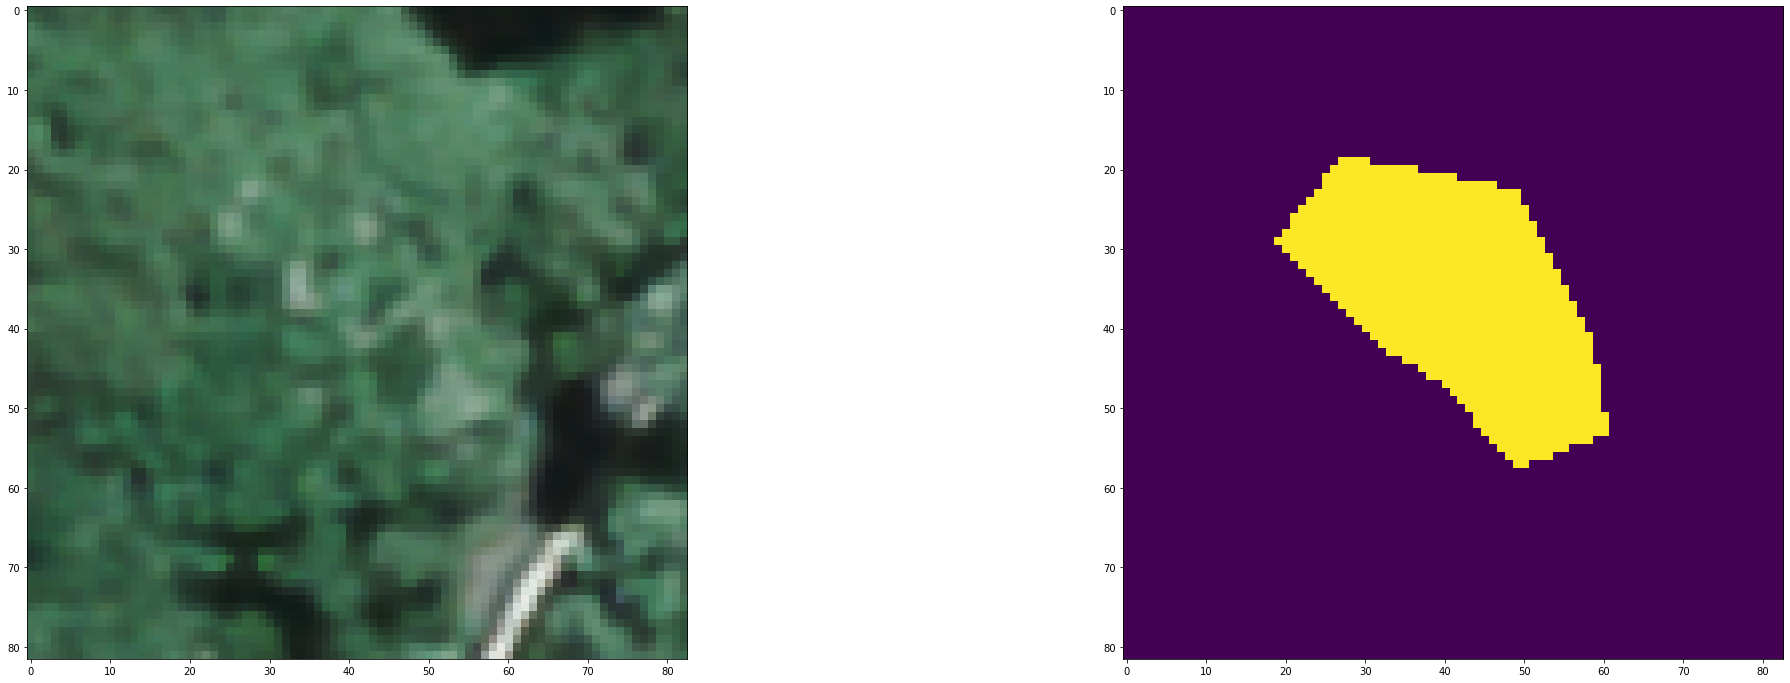

BQ31_500_044065


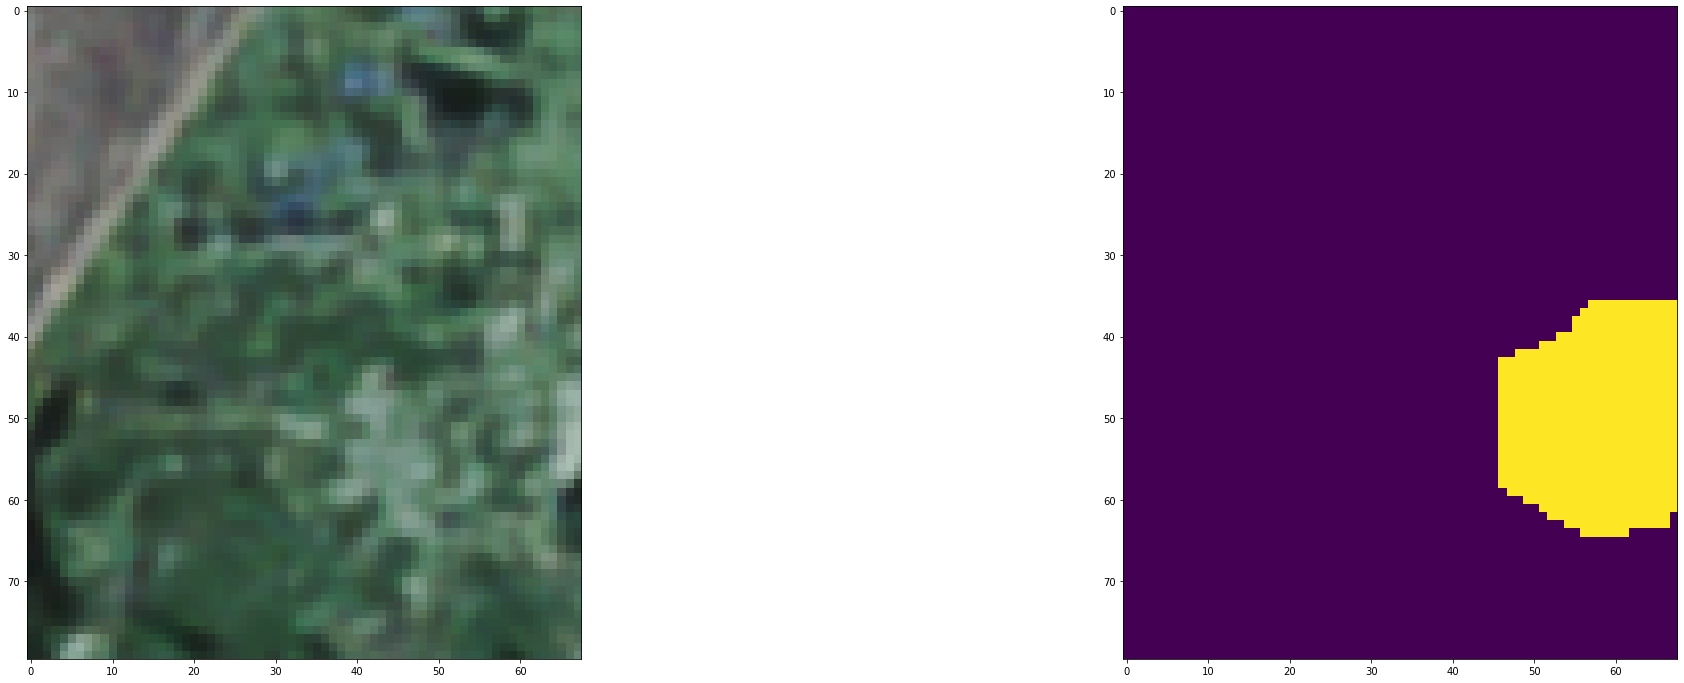

BQ31_500_044065


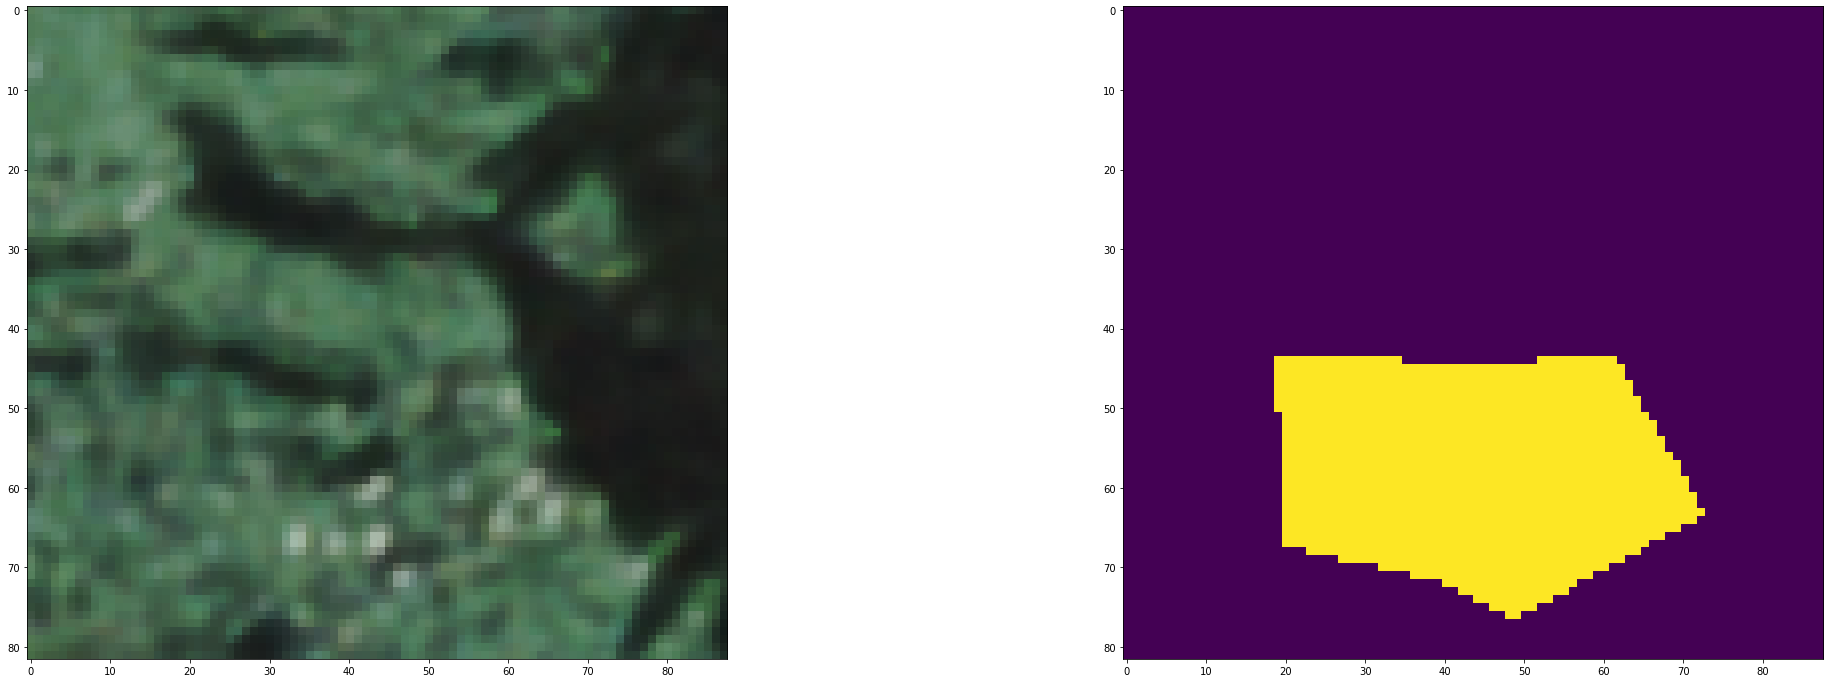

BQ31_500_044065


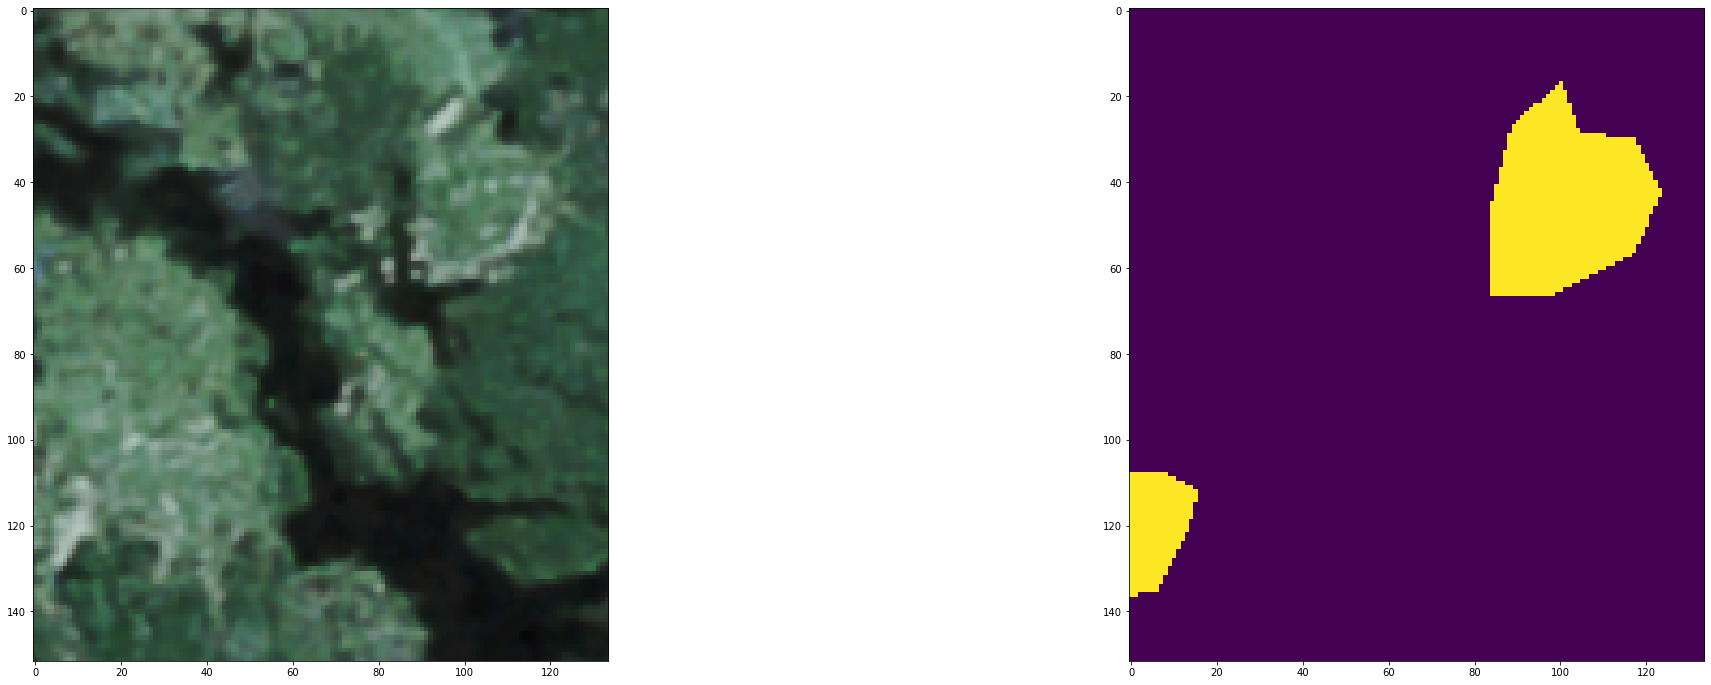

BQ31_500_044065


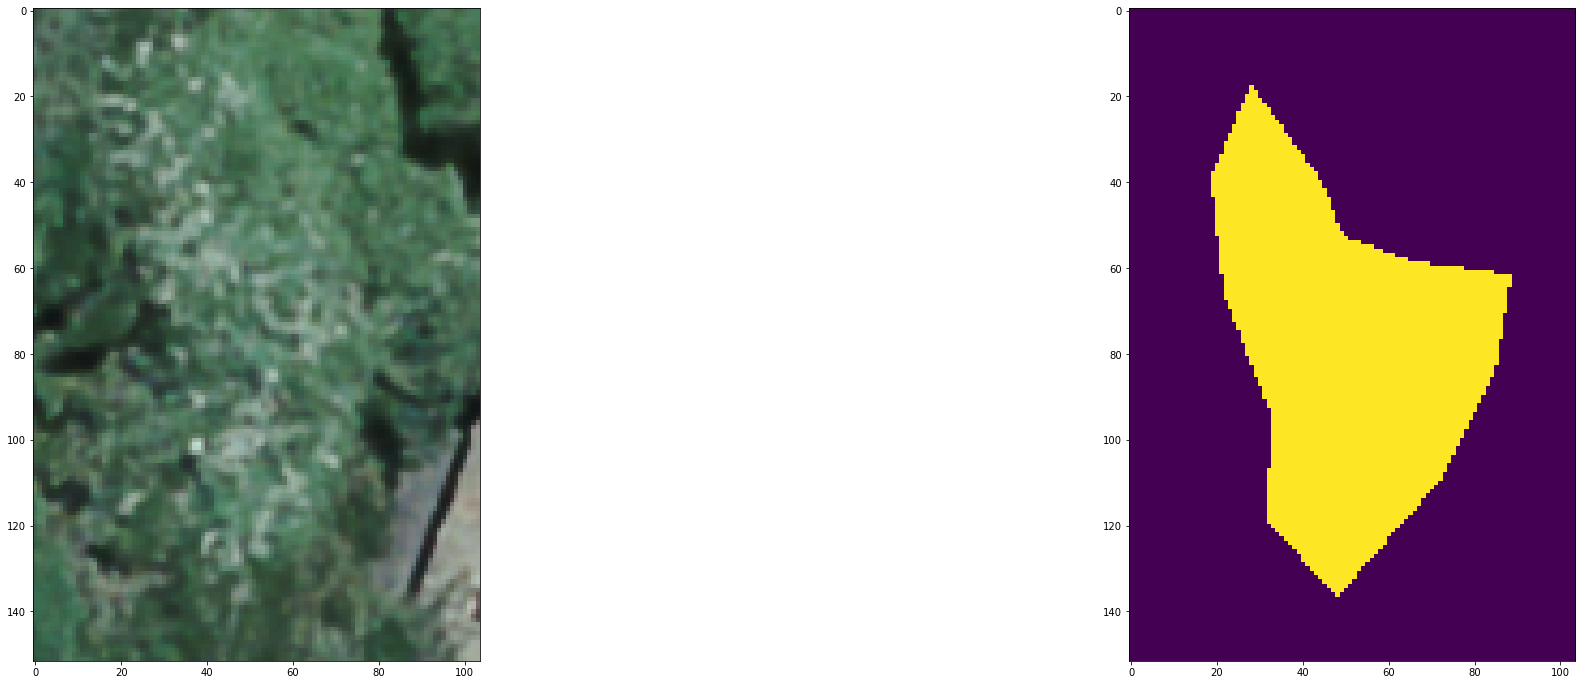

BQ31_500_043066


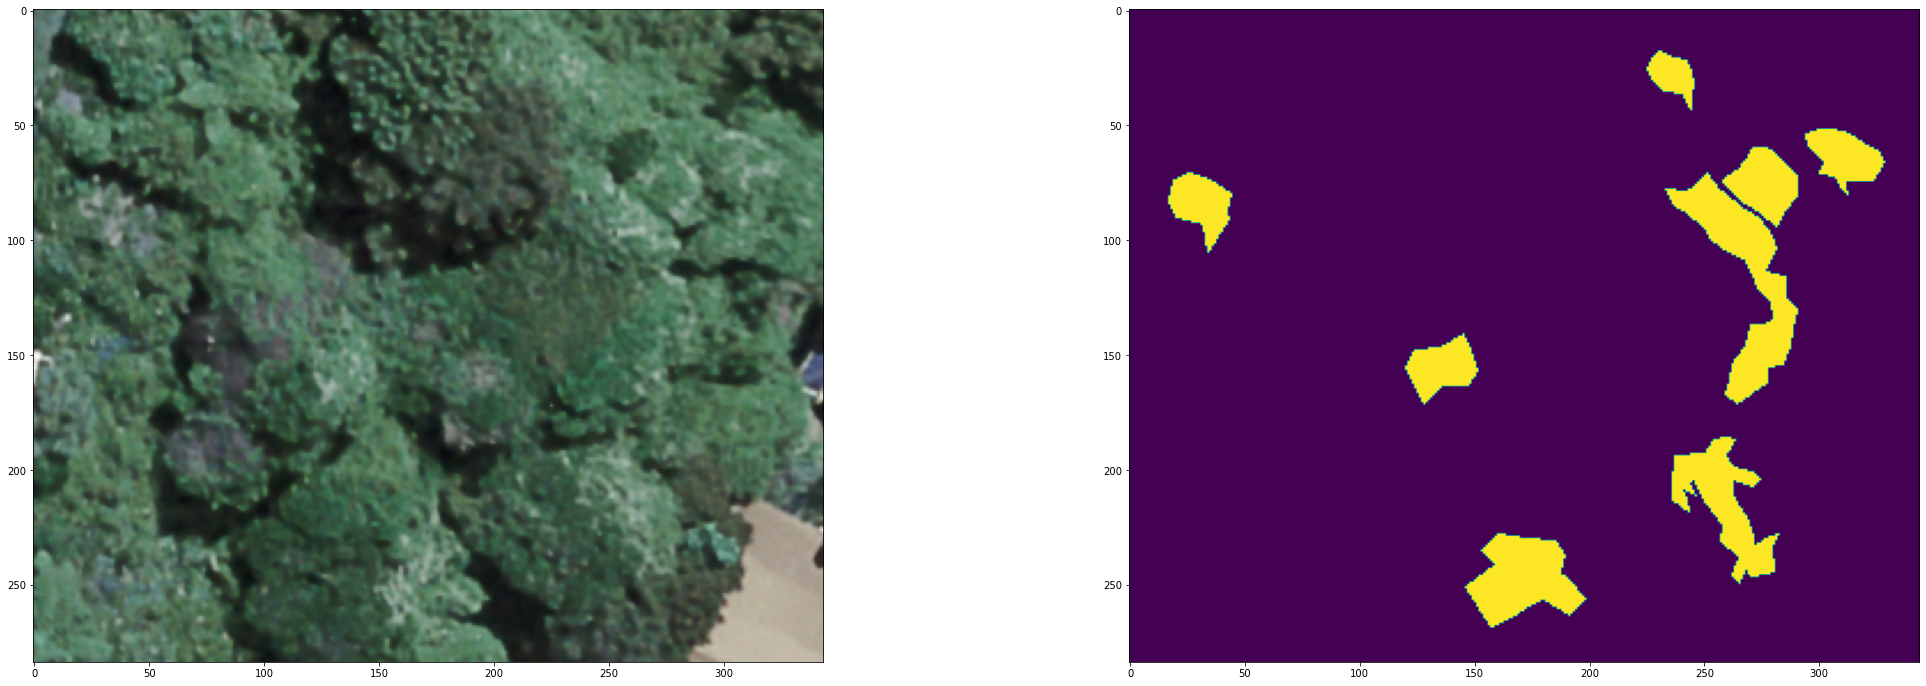

BQ31_500_042064


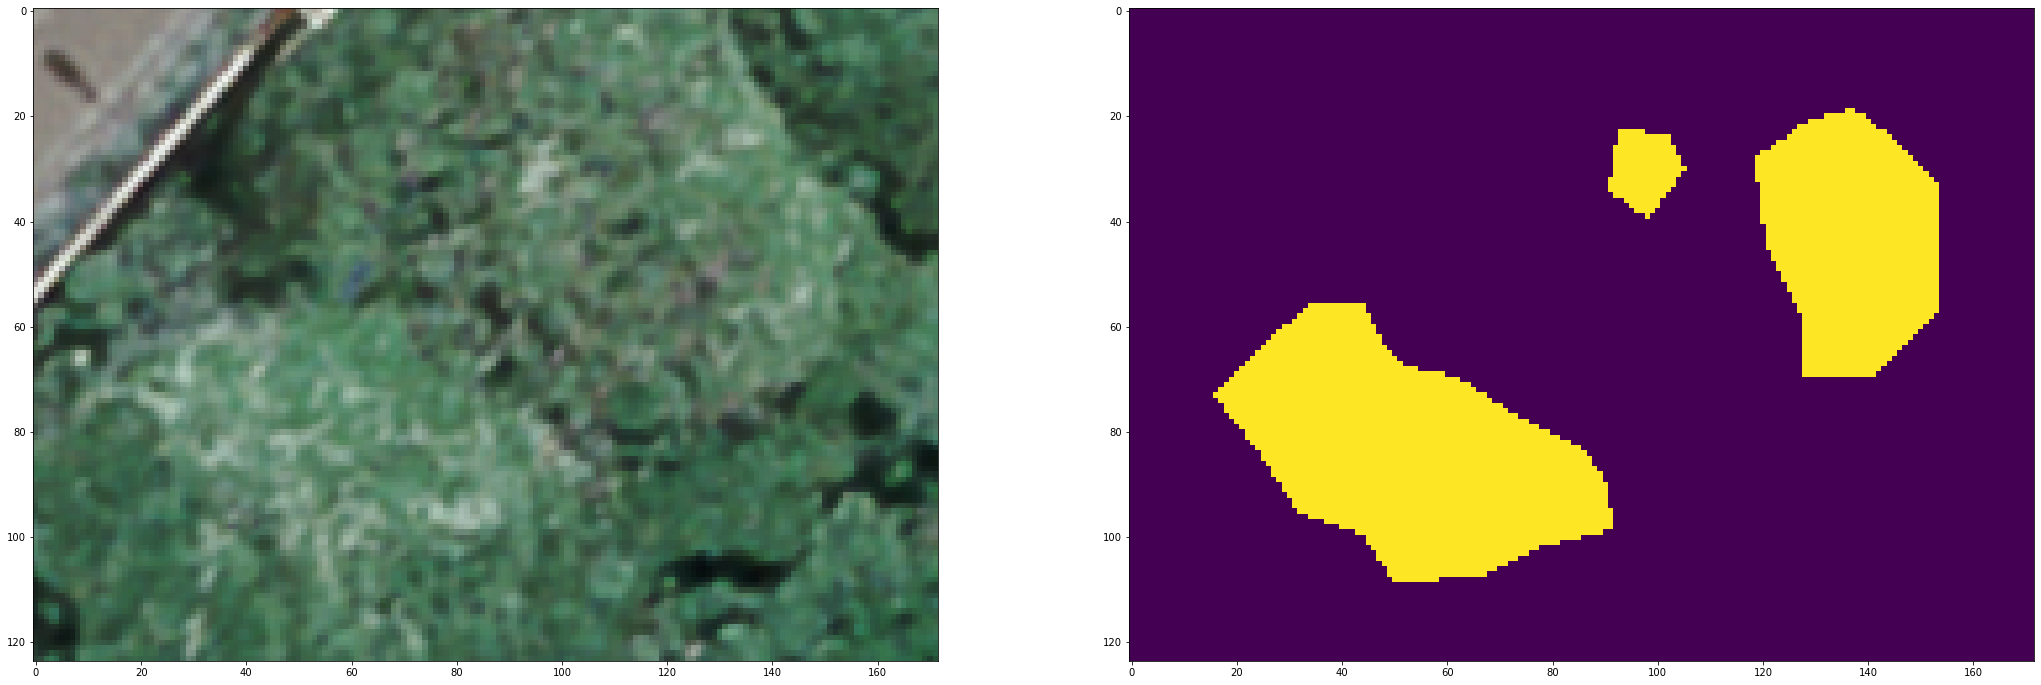

BQ31_500_042064


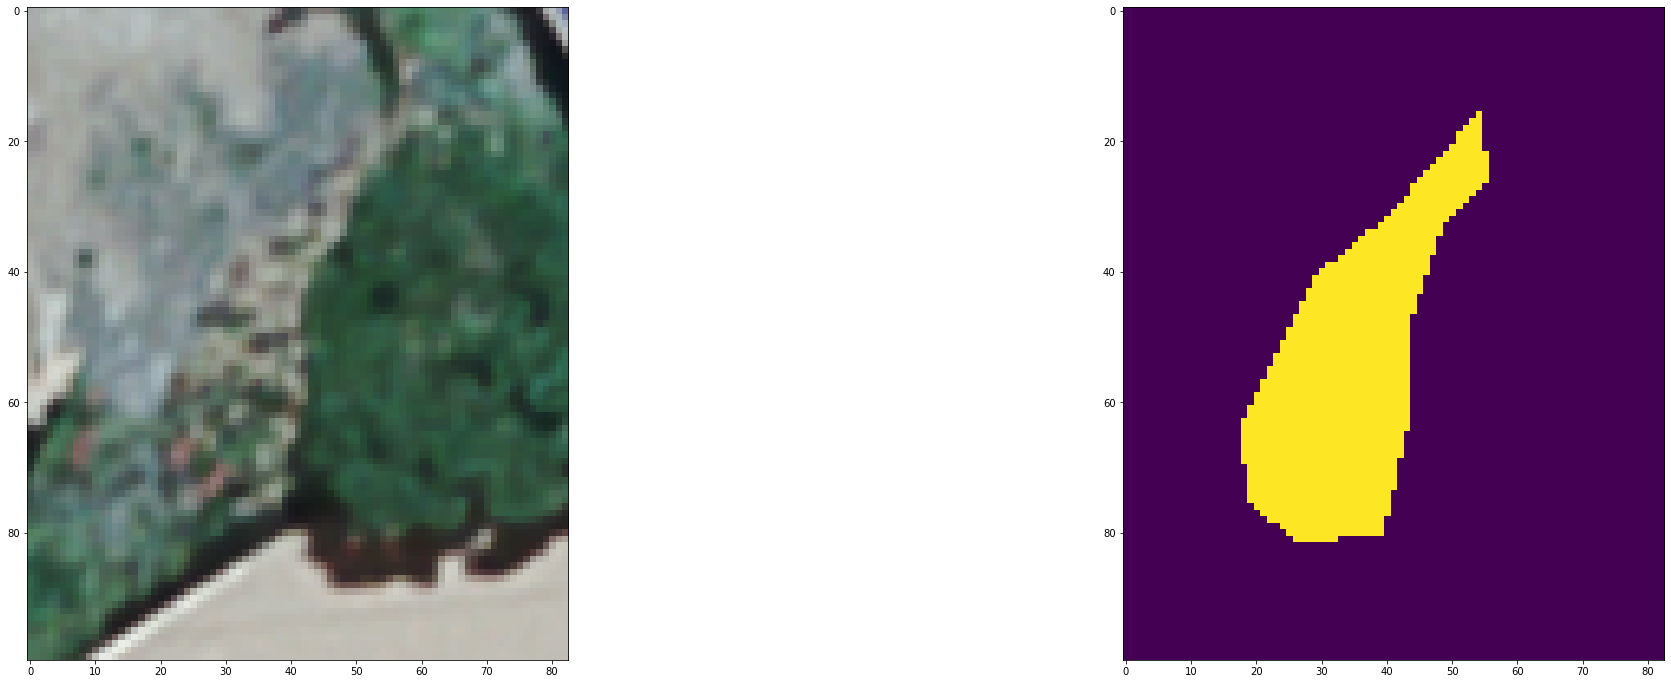

BQ31_500_042064


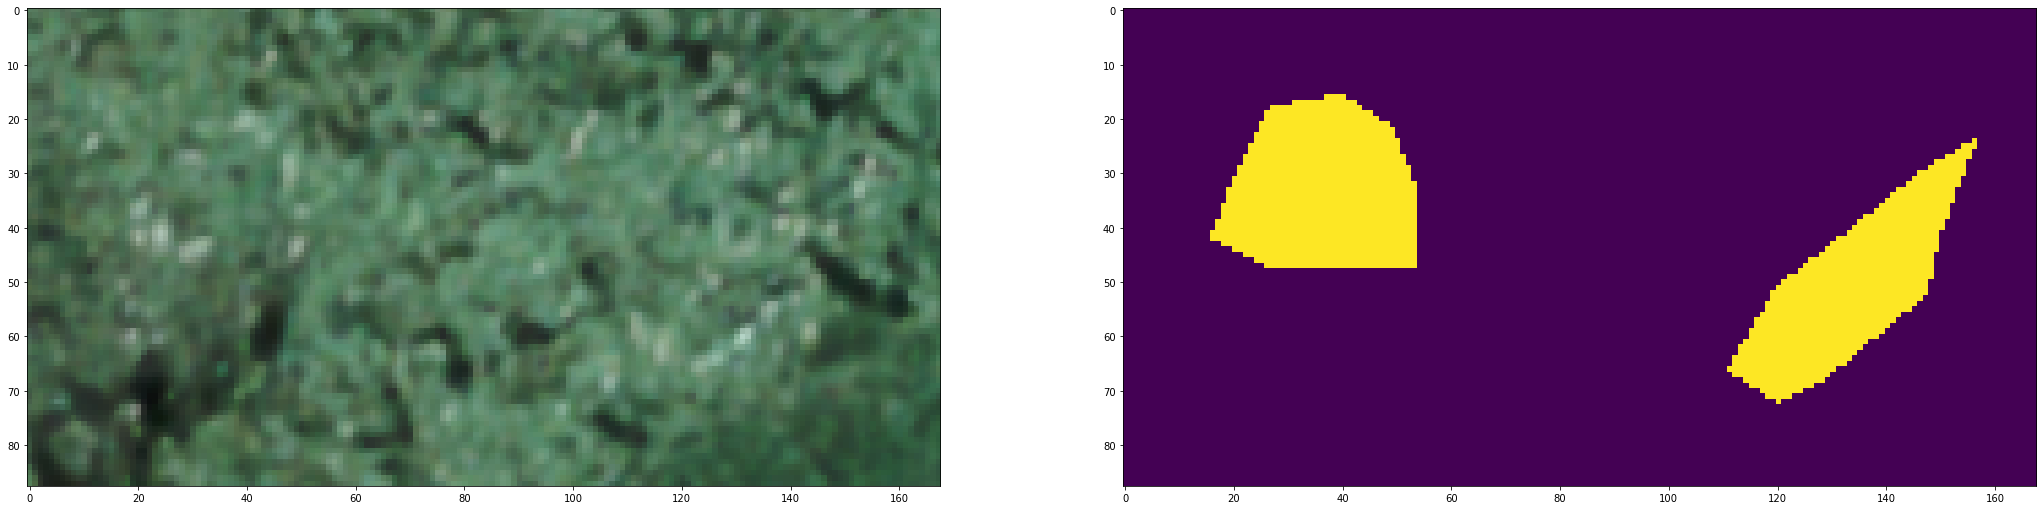

BQ31_500_042064


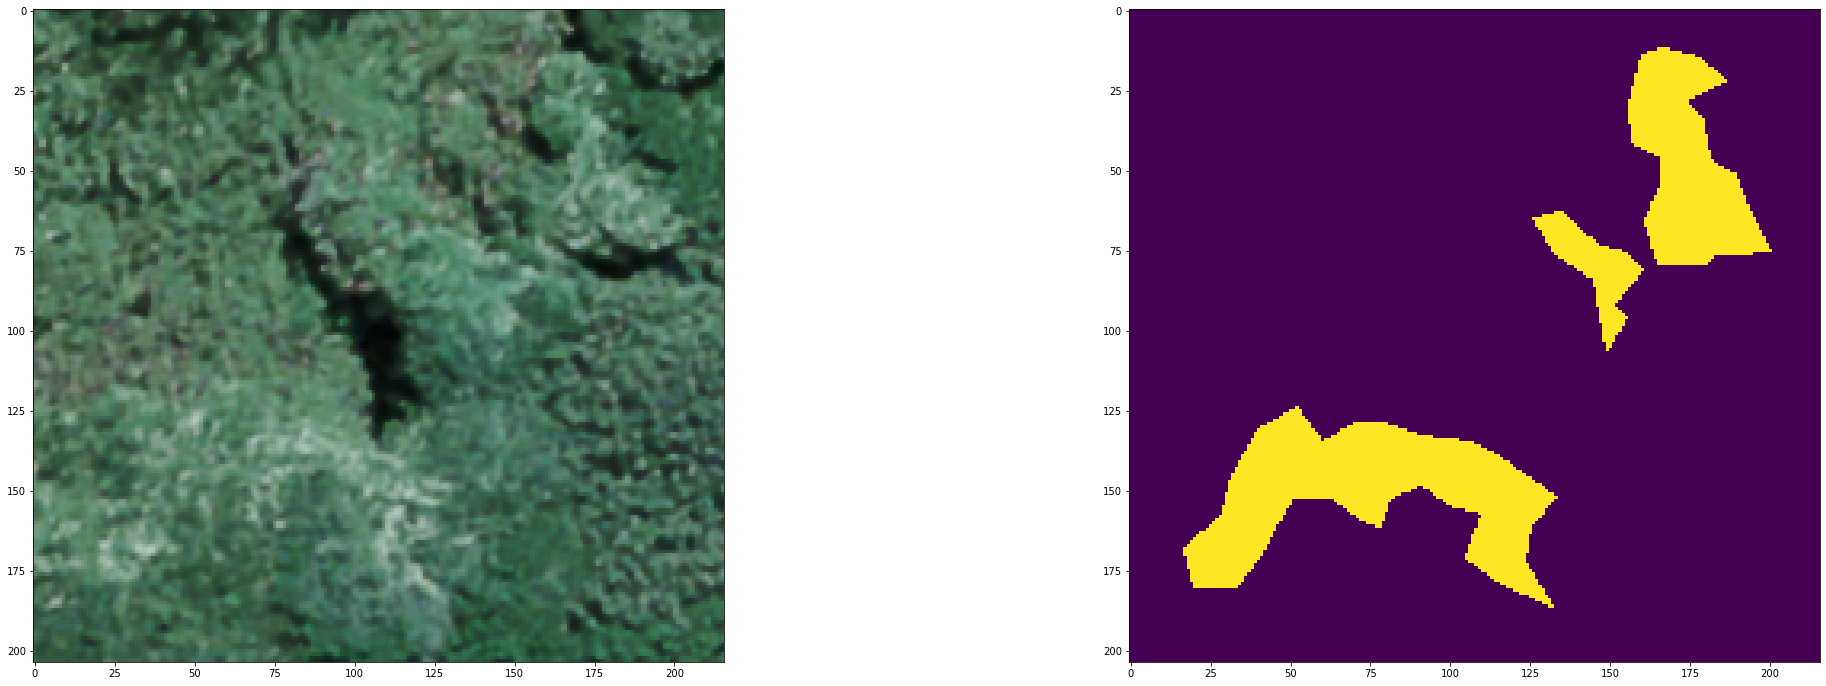

BQ31_500_041065


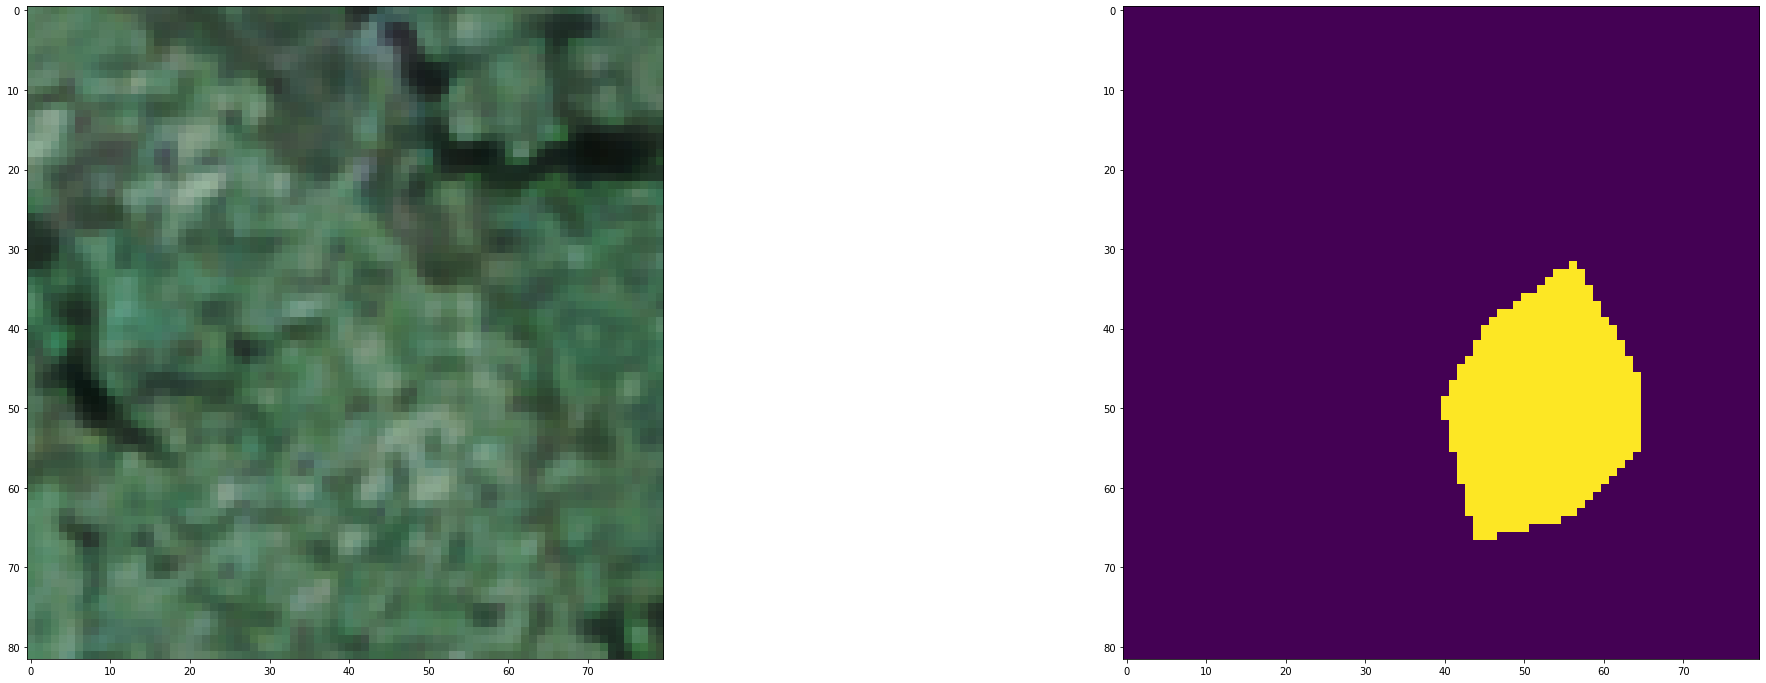

BQ31_500_041065


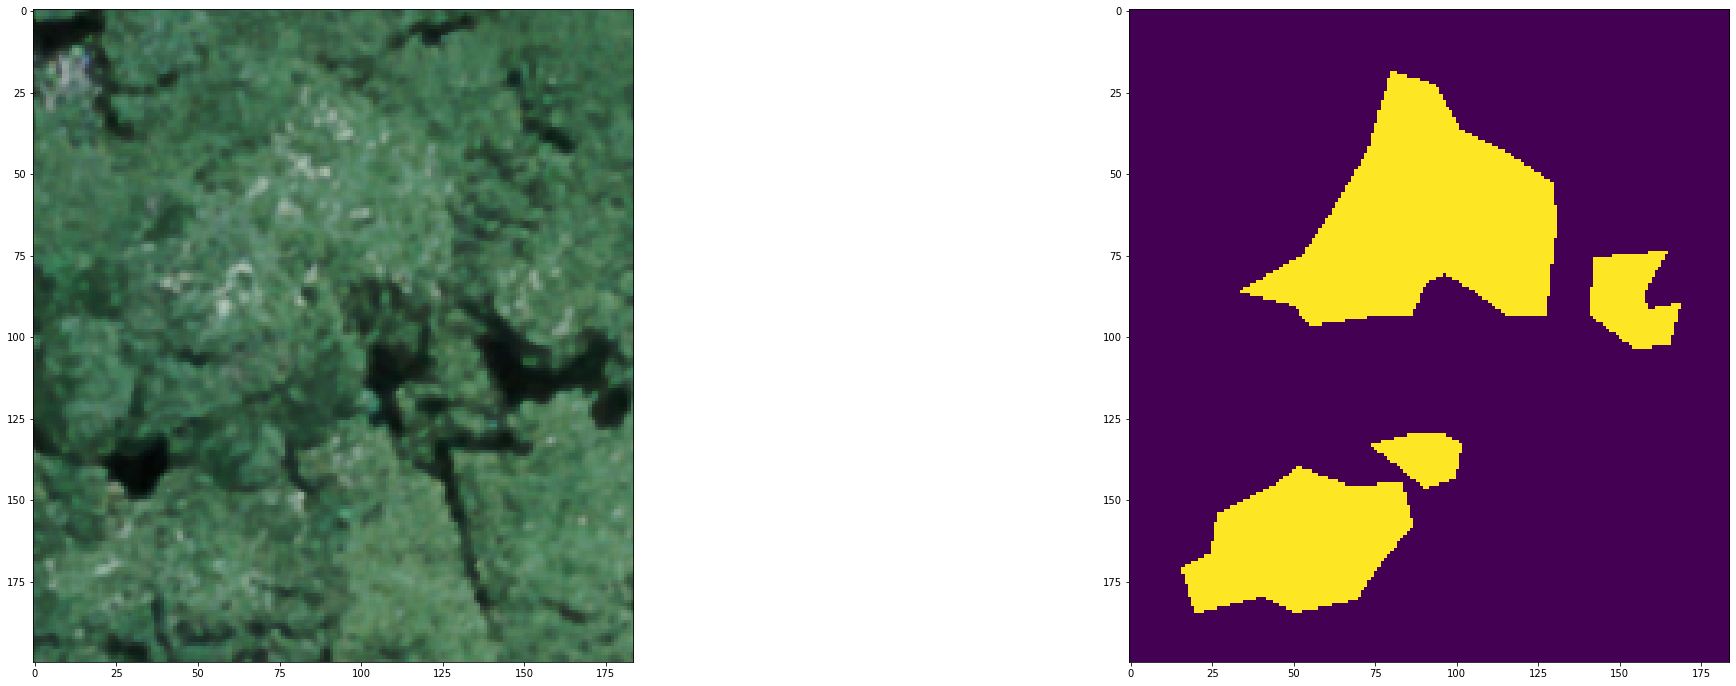

BQ31_500_041065


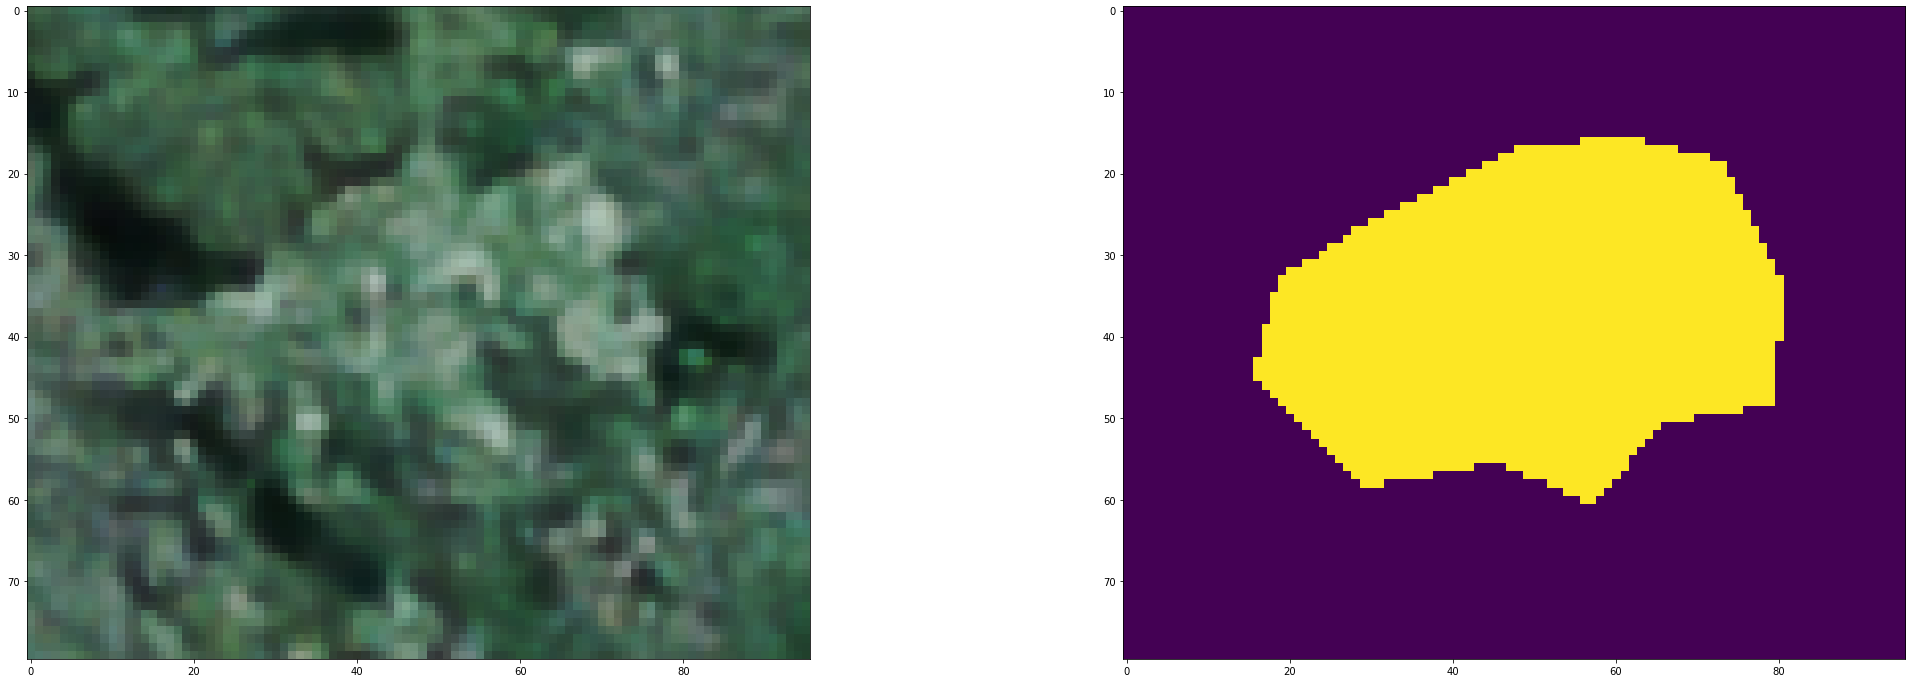

BQ31_500_041065


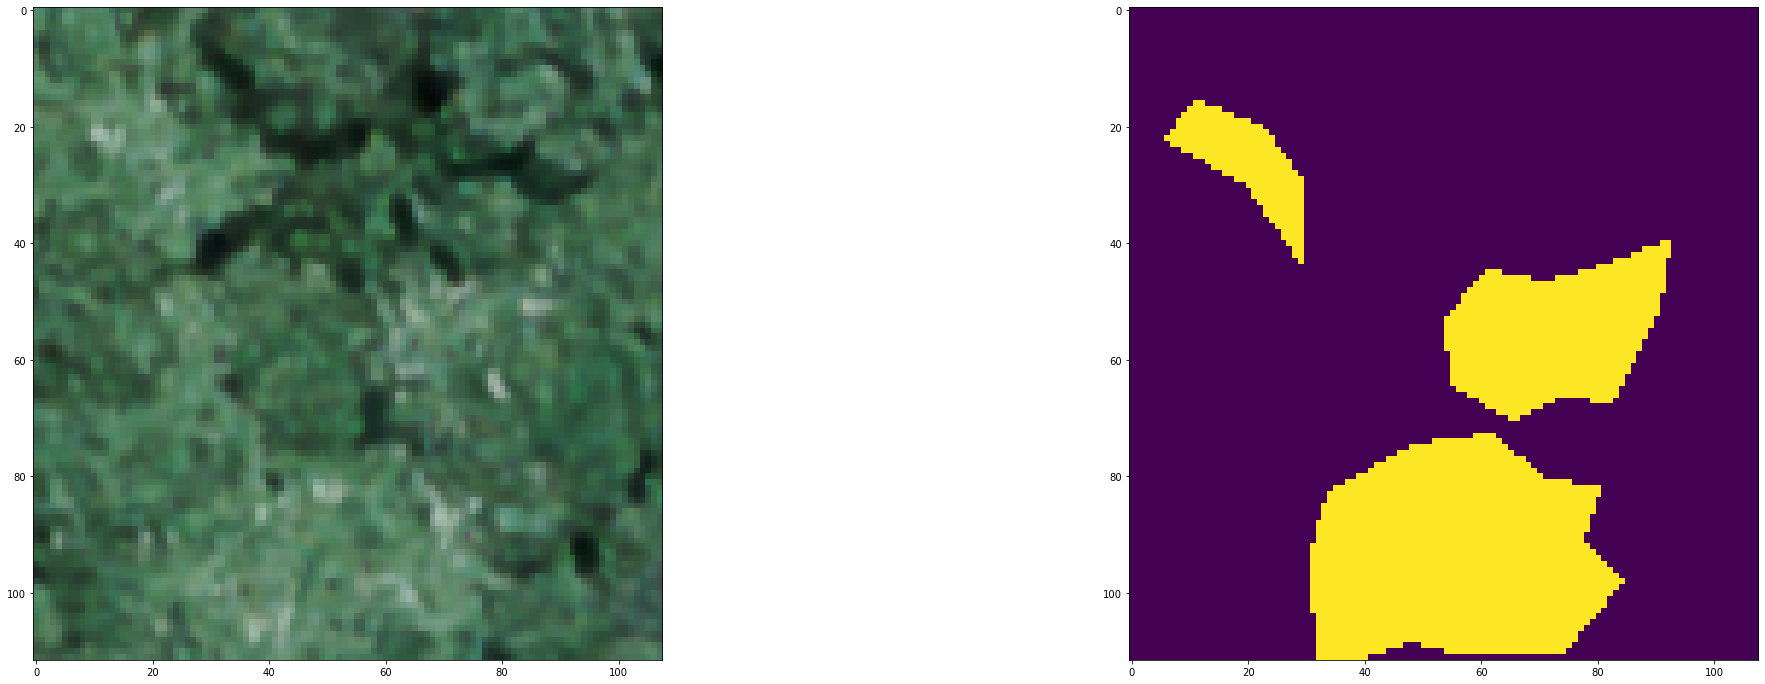

BQ31_500_041065


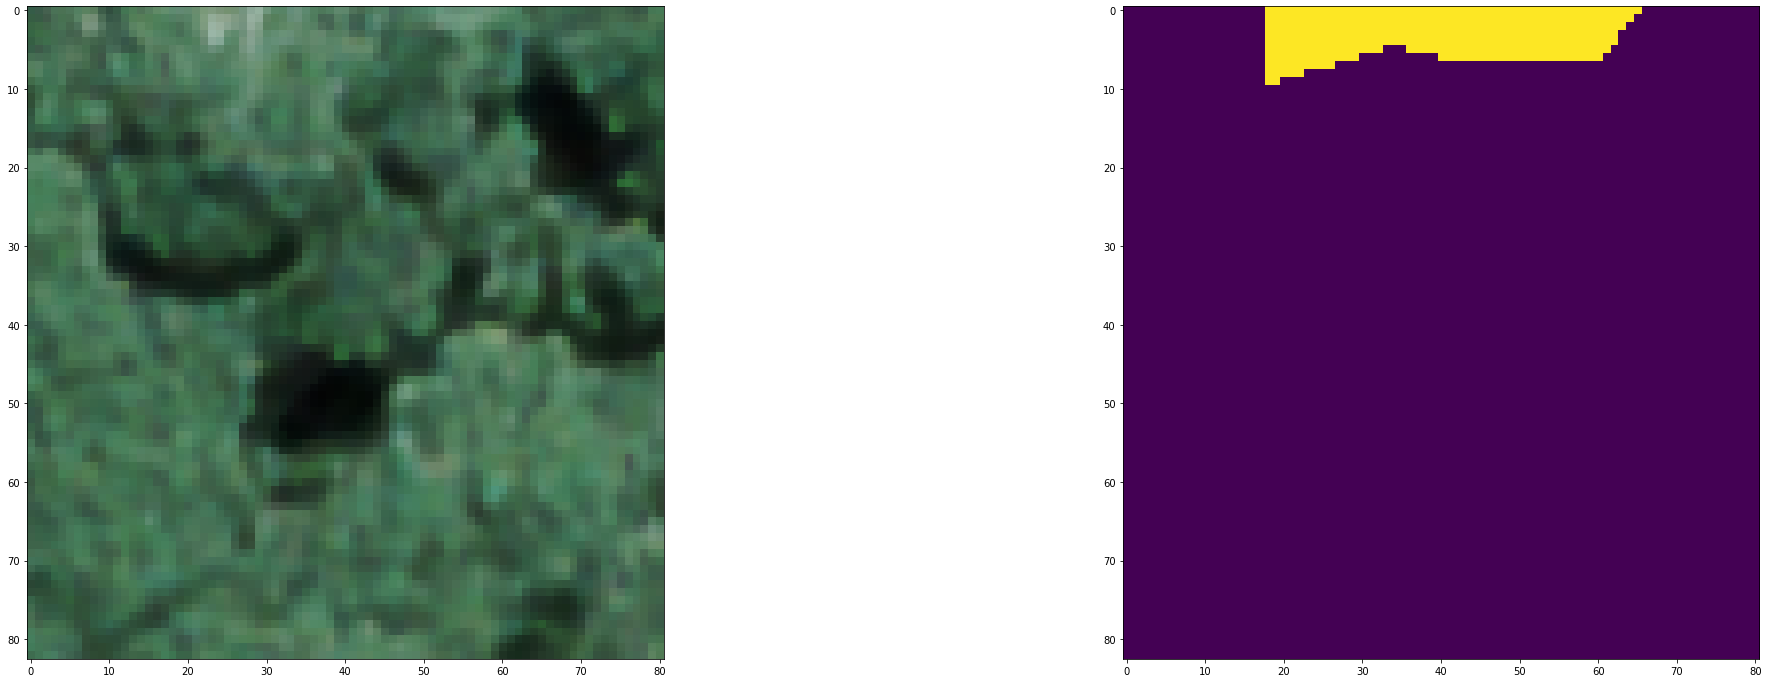

BQ31_500_041065


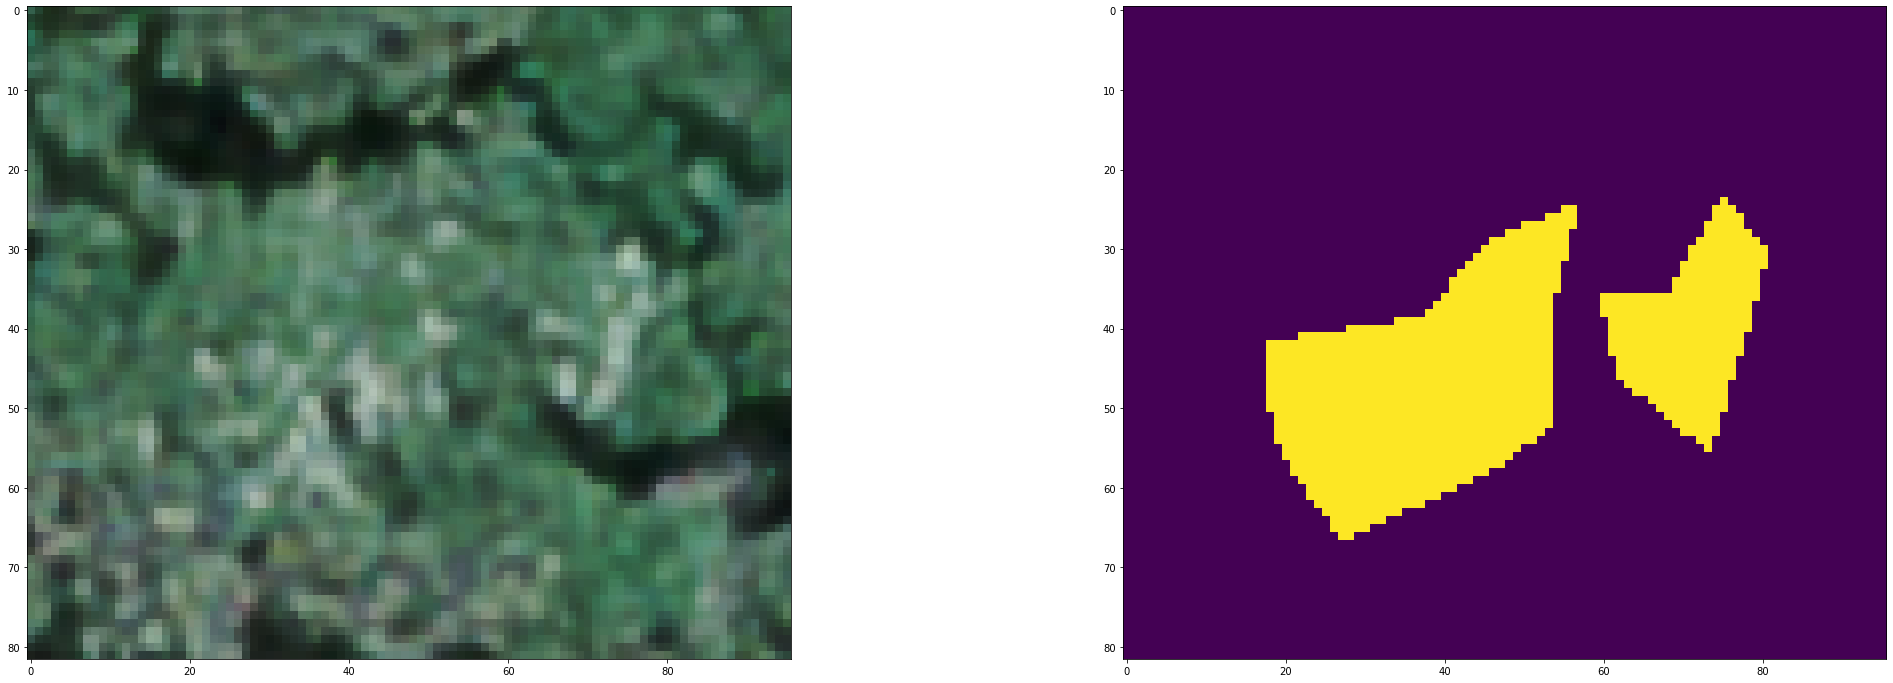

BQ31_500_041068


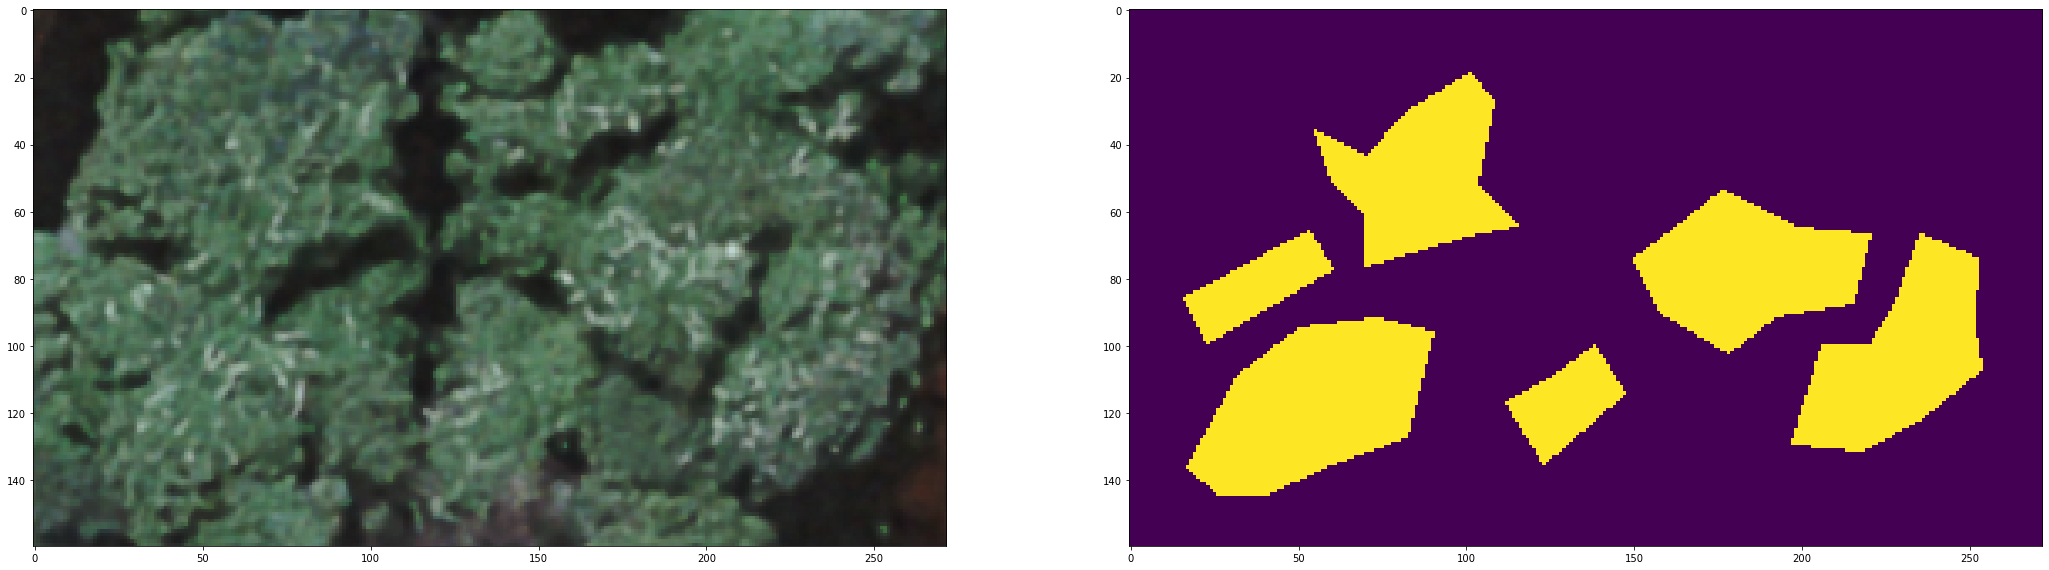

BQ31_500_041068


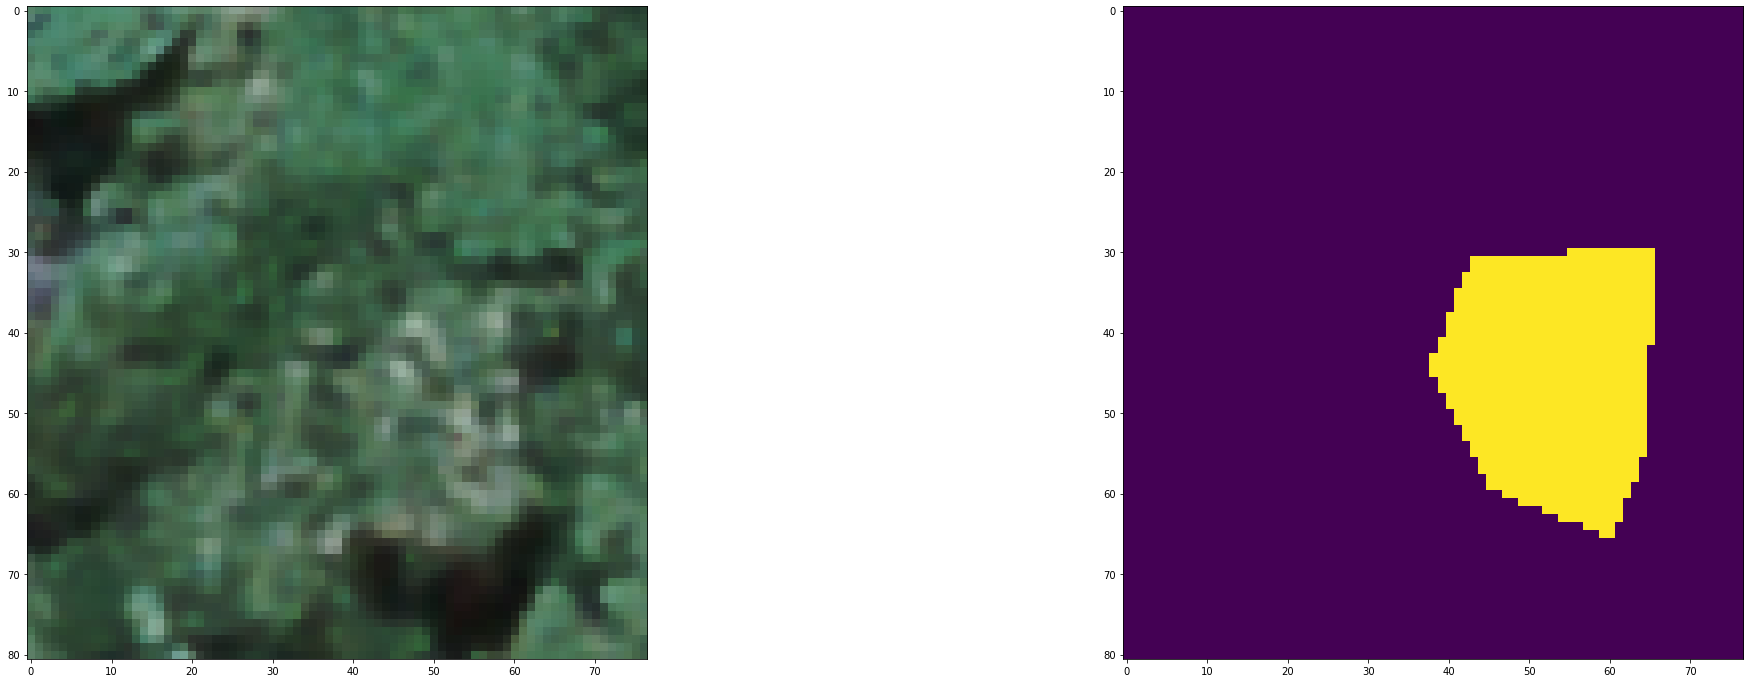

BQ31_500_041068


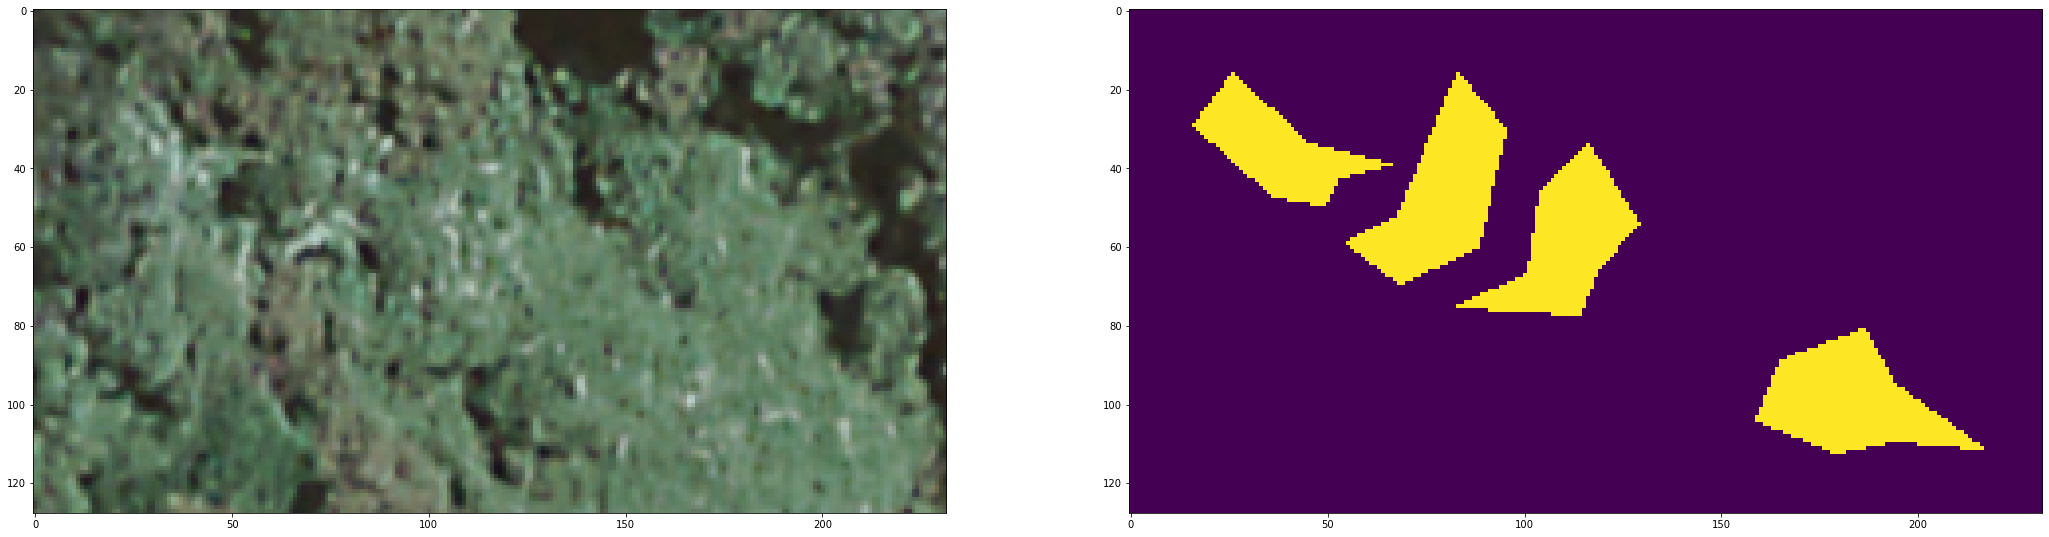

BQ31_500_041068


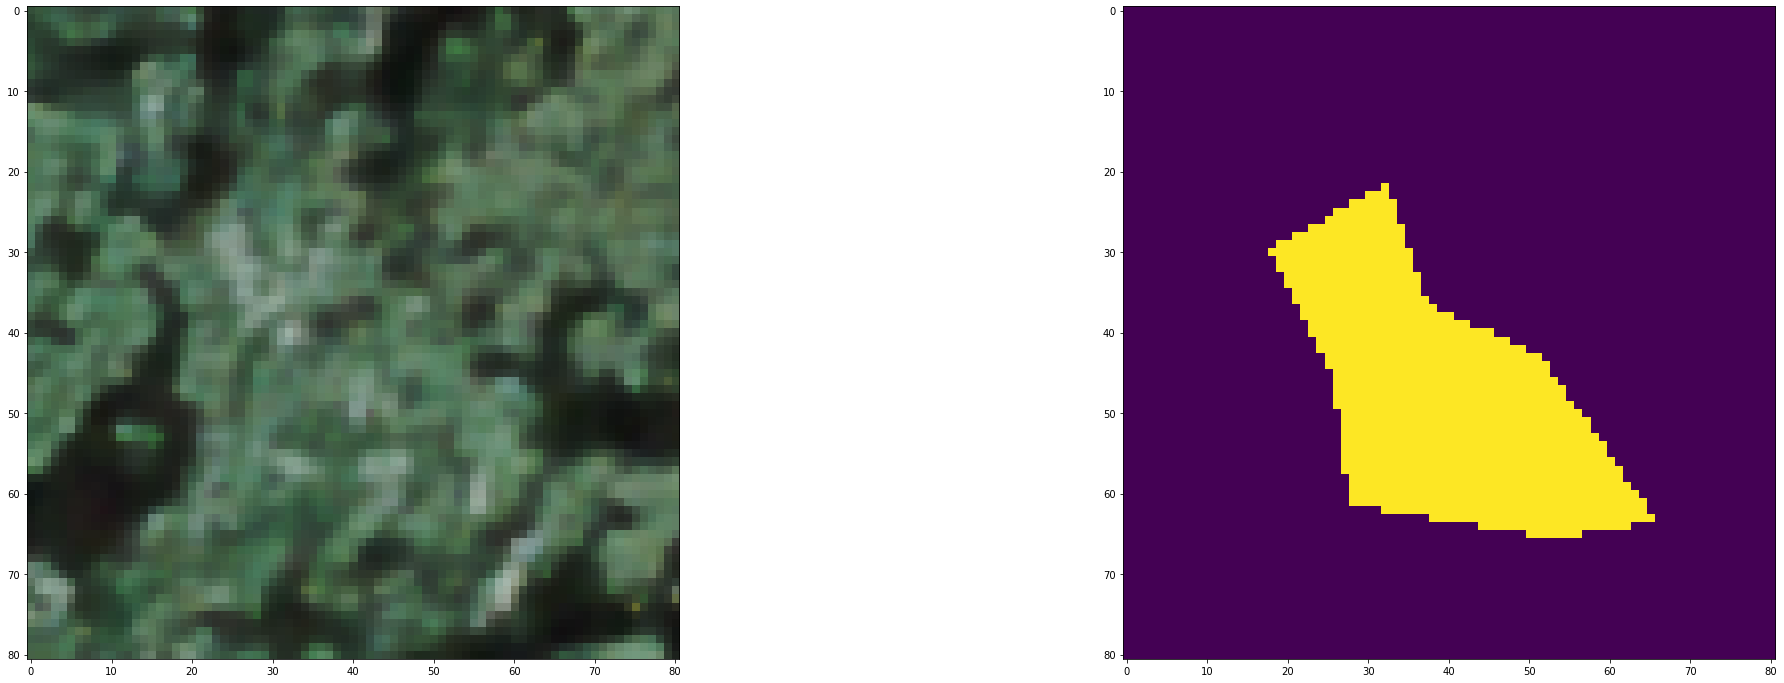

In [50]:
for index in range(0, len(cropped_samples)):
    print(cropped_names[index])
    fig, ax = plt.subplots(1, 2, figsize=(36,12))
    ax[0].imshow(cropped_samples[index])
    ax[1].imshow(cropped_actuals[index])
    plt.show()